In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

%matplotlib notebook

In [4]:
%matplotlib notebook

In [5]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_compare'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


#Need to: 
#bin commands 
#1)
#magnitude bins, percentiles: 0-25, 25-50, 50-75, 75-100
#2)
#angle bins: 8 bins starting centered at 0.  

In [5]:
list(df.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'task',
 'tc',
 'target',
 'trial',
 'bin',
 'trial_start',
 'trial_stop',
 'target_size',
 'obs_size']

In [6]:
#Useful for analysis:
#Add a time till end of trial: 

#Trial boundaries:
# trial_start = np.where((df['trial_start']==1))[0]
trial_start = np.where((df['bin']==-10.0))[0]
trial_stop = np.where((df['trial_stop']==1))[0]
trial_bound = np.vstack((trial_start,trial_stop)).T
num_trials = trial_bound.shape[0]

df['bin_end'] = 0
df['prog'] = 0

for bnd in trial_bound:
    bin_data = df['bin'][bnd[0]:bnd[1]+1]
    last_bin = bin_data.iloc[-1]
    bin_end = last_bin-bin_data
    prog = bin_data/last_bin
    #ASSIGN:
    df['bin_end'][bnd[0]:bnd[1]+1] = bin_end
    df['prog'][bnd[0]:bnd[1]+1] = prog

c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
print(df['bin'][0:56])
print(df['bin_end'][0:56])
print(df['prog'][0:56])

0    -10.0
1     -9.0
2     -8.0
3     -7.0
4     -6.0
5     -5.0
6     -4.0
7     -3.0
8     -2.0
9     -1.0
10     0.0
11     1.0
12     2.0
13     3.0
14     4.0
15     5.0
16     6.0
17     7.0
18     8.0
19     9.0
20    10.0
21    11.0
22    12.0
23    13.0
24    14.0
25    15.0
26    16.0
27    17.0
28    18.0
29    19.0
30    20.0
31    21.0
32    22.0
33    23.0
34    24.0
35    25.0
36    26.0
37    27.0
38    28.0
39    29.0
40    30.0
41    31.0
42    32.0
43    33.0
44    34.0
45    35.0
46    36.0
47    37.0
48    38.0
49    39.0
50    40.0
51    41.0
52    42.0
53    43.0
54    44.0
55   -10.0
Name: bin, dtype: float64
0     54.0
1     53.0
2     52.0
3     51.0
4     50.0
5     49.0
6     48.0
7     47.0
8     46.0
9     45.0
10    44.0
11    43.0
12    42.0
13    41.0
14    40.0
15    39.0
16    38.0
17    37.0
18    36.0
19    35.0
20    34.0
21    33.0
22    32.0
23    31.0
24    30.0
25    29.0
26    28.0
27    27.0
28    26.0
29    25.0
30    24.0
31    23.0
32    

In [7]:
#First: Polar coordinates: 

# 1) Convert stuff to polar, 2) center angles at target angle, 3) calculate distance to target
# 1) Convert stuff to polar
df['p_mag'], df['p_angle'] = bmi_b.cartesian2polar(df['kin_py'], df['kin_px'])
df['v_mag'], df['v_angle'] = bmi_b.cartesian2polar(df['kin_vy'], df['kin_vx'])
df['u_p_mag'], df['u_p_angle'] = bmi_b.cartesian2polar(df['u_py'], df['u_px'])
df['u_v_mag'], df['u_v_angle'] = bmi_b.cartesian2polar(df['u_vy'], df['u_vx'])
# 2) Center @ target angle: 
d_list = ['p_angle', 'v_angle', 'u_p_angle', 'u_v_angle']
for d in d_list:
    data = df[d]
    zeros = np.zeros(data.shape)
    t_angle = target_angle[df['target'].astype(int)]
    df[d+'_ctr'] = bmi_b.center_angle(df[d], zeros, t_angle)
# 3) distance to target
error = df.loc[:, 'kin_px':'kin_py']-target_pos[df['target'].astype(int),:]
df['d2target'] = np.linalg.norm(error,ord=2,axis=1)
df['x_error'] = error.loc[:,'kin_px']
df['y_error'] = error.loc[:,'kin_py']

In [8]:
df['u_v_angle'].min()*180/np.pi

-179.97251025514896

In [9]:
df['u_v_angle'].max()*180/np.pi

179.99381945207733

In [10]:
list(df.columns)

#  'u_px',
#  'u_py',
#  'u_vx',
#  'u_vy',

#  'u_v_mag',
#  'u_v_angle',

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'task',
 'tc',
 'target',
 'trial',
 'bin',
 'trial_start',
 'trial_stop',
 'target_size',
 'obs_size',
 'bin_end',
 'prog',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 'u_v_mag',
 'u_v_angle',
 'p_angle_ctr',
 'v_angle_ctr',
 'u_p_angle_ctr',
 'u_v_angle_ctr',
 'd2target',
 'x_error',
 'y_error']

In [10]:
df.head()

n_0  n_1  n_2  n_3  n_4  n_5  n_6  n_7  n_8  n_9  ...  u_p_angle   u_v_mag  \
0  2.0  1.0  0.0  0.0  1.0  4.0  2.0  0.0  0.0  0.0  ...   1.903203  0.979791   
1  2.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0  ...   1.343763  2.550964   
2  1.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  ...   1.107820  1.538962   
3  5.0  0.0  0.0  1.0  0.0  4.0  4.0  0.0  0.0  0.0  ...  -1.608672  0.868451   
4  4.0  0.0  0.0  0.0  1.0  3.0  0.0  0.0  0.0  0.0  ...   1.202795  1.099681   

   u_v_angle  p_angle_ctr  v_angle_ctr  u_p_angle_ctr  u_v_angle_ctr  \
0   1.903203     3.089594    -2.668033      -2.023787      -2.023787   
1   1.343763     3.107998    -2.663977      -2.583228      -2.583228   
2   1.107820     3.122842    -2.811559      -2.819171      -2.819171   
3  -1.608672     3.121874     2.781544       0.747523       0.747523   
4   1.202795     3.122433    -3.084737      -2.724196      -2.724196   

    d2target    x_error    y_error  
0  18.560671  13.435452  12.805746  
1  18.844048  13.533209  13.112986  
2  19.180040  13.683511  13.440069  
3  19.319563  13.790328  13.530425  
4  19.482174  13.903848  13.646909  

[5 rows x 78 columns]

### BINS: 

In [8]:
#1) magnitude bins: 
num_mag_bins = 4
mag_bin_perc = np.array([0,25,50,75,100])
mag_data = df['u_v_mag']
#mag_data = df['u_v_mag'][df['bin']>=0] - we didn't do this, because we want to be able to bin all data, negative bins
mag_bin = np.percentile(mag_data, mag_bin_perc)
mag_bin_edges = np.vstack((mag_bin[0:-1], mag_bin[1:]))
mag_bin_c = mag_bin_edges.mean(axis=0)

In [9]:
print(mag_bin)
print(mag_bin_edges)
print(mag_bin_c)

[0.00880115 0.80946662 1.28016195 1.86169573 7.01433267]
[[0.00880115 0.80946662 1.28016195 1.86169573]
 [0.80946662 1.28016195 1.86169573 7.01433267]]
[0.40913388 1.04481428 1.57092884 4.4380142 ]


In [13]:
target0_angle = -3*(2*np.pi)/8
print(target0_angle*180/np.pi)

-135.0


In [10]:
#2) angle bins: 
num_angle_bins = 8

T0_angle = -3*(2*np.pi)/8
angle_bin_c = np.linspace(T0_angle, T0_angle+np.pi*2, num=num_angle_bins+1, endpoint=True)
# angle_bin_c[angle_bin_c > np.pi] = angle_bin_c[angle_bin_c > np.pi] - 2*np.pi #center at angle 0 instead of 180
angle_bin = angle_bin_c-np.pi*2/16.0
# angle_bin[angle_bin < -np.pi] = angle_bin[angle_bin < -np.pi] + 2*np.pi
angle_bin_edges = np.vstack((angle_bin[0:-1], angle_bin[1:]))

In [15]:
#TODO: make the bin angles match the target directions

In [16]:
print(angle_bin_c*180/np.pi)
print(angle_bin*180/np.pi)
print(angle_bin_edges*180/np.pi)

[-135.  -90.  -45.    0.   45.   90.  135.  180.  225.]
[-157.5 -112.5  -67.5  -22.5   22.5   67.5  112.5  157.5  202.5]
[[-157.5 -112.5  -67.5  -22.5   22.5   67.5  112.5  157.5]
 [-112.5  -67.5  -22.5   22.5   67.5  112.5  157.5  202.5]]


In [11]:
#center angles for binning: 
angle_center_for_binning = (angle_bin[-1]+angle_bin[0])/2.0
print('angle_center:', angle_center_for_binning*180/np.pi)

angle_vars = ['p_angle', 'v_angle', 'u_p_angle', 'u_v_angle']
for d in angle_vars:
    df[d] = bmi_b.center_angle_v2(np.array(df[d]), angle_center_for_binning)
print('min centered angle:', np.min(df['u_v_angle'])*180/np.pi)
print('max centered angle:', np.max(df['u_v_angle'])*180/np.pi)

('angle_center:', 22.5)
('min centered angle:', -157.4975492637699)
('max centered angle:', 202.46708261619673)


In [12]:
#BIN DATA: 
bin_dic = {}
bin_dic[0] = mag_bin_edges
bin_dic[1] = angle_bin_edges

data2bin = np.array(df[['u_v_mag','u_v_angle']])
bin_r, hist_r = bmi_b.bin_vec_data(data2bin, bin_dic)
df['u_v_mag_bin']=bin_r[:,0]
df['u_v_angle_bin']=bin_r[:,1]

In [20]:
bin_r[:,0].max()

3.0

In [21]:
bin_r[:,1].max()

7.0

In [22]:
df['u_v_mag_bin']=bin_r[:,0]
df['u_v_angle_bin']=bin_r[:,1]

In [ ]:
#Plot bins and the vector: 

In [208]:
list(df.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'task',
 'tc',
 'target',
 'trial',
 'bin',
 'trial_start',
 'trial_stop',
 'target_size',
 'obs_size',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 'u_v_mag',
 'u_v_angle',
 'p_angle_ctr',
 'v_angle_ctr',
 'u_p_angle_ctr',
 'u_v_angle_ctr',
 'd2target',
 'x_error',
 'y_error',
 'bin_end']

<IPython.core.display.Javascript object>


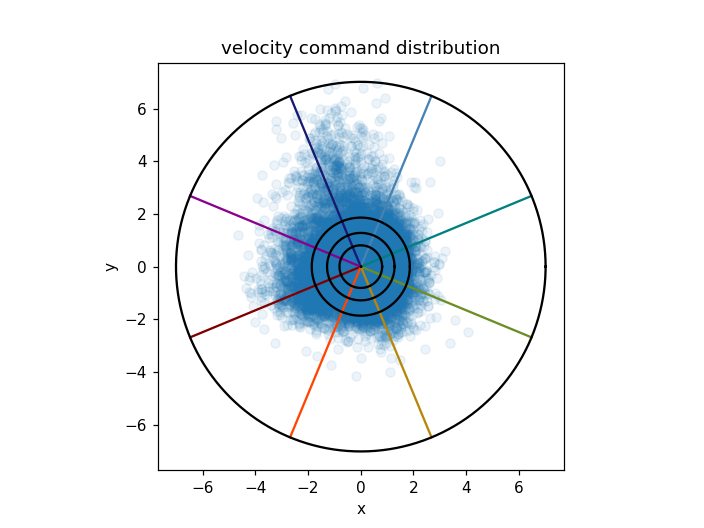

Text(0.5,1,'velocity command distribution')

In [19]:
i = 10
plt.figure()
plt.scatter(df['u_vx'], df['u_vy'],alpha=0.08)

for i,b in enumerate(angle_bin_edges.T):
    x1 = np.cos(b[0])*mag_bin[-1]
    y1 = np.sin(b[0])*mag_bin[-1]
    plt.plot([0, x1], [0, y1], color=target_color[i])
for b in mag_bin:
    theta = np.linspace(0,2*np.pi,1000)
    plt.plot(b*np.cos(theta), b*np.sin(theta), 'k')
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')
plt.title('velocity command distribution')

In [20]:
angle_bin_c

array([-2.35619449, -1.57079633, -0.78539816,  0.        ,  0.78539816,
        1.57079633,  2.35619449,  3.14159265,  3.92699082])

In [21]:
def plot_command_bin():
    for i,b in enumerate(angle_bin_edges.T):
        x1 = np.cos(b[0])*mag_bin[-1]
        y1 = np.sin(b[0])*mag_bin[-1]
#         plt.plot([0, x1], [0, y1], color=target_color[i])
        plt.plot([0, x1], [0, y1], '--', color=np.ones(3)*0.8,zorder=0)#'k')
    for i,a in enumerate(angle_bin_c[:-1]): 
        x1 = np.cos(a)*mag_bin[-1]
        y1 = np.sin(a)*mag_bin[-1]        
        plt.plot([0, x1], [0, y1], color=target_color[i], linewidth=3,zorder=0)
    
    for b in mag_bin:
        theta = np.linspace(0,2*np.pi,1000)
        plt.plot(b*np.cos(theta), b*np.sin(theta), 'k',zorder=0)
    plt.axis('square')
    plt.xlabel('x')
    plt.ylabel('y')

<IPython.core.display.Javascript object>


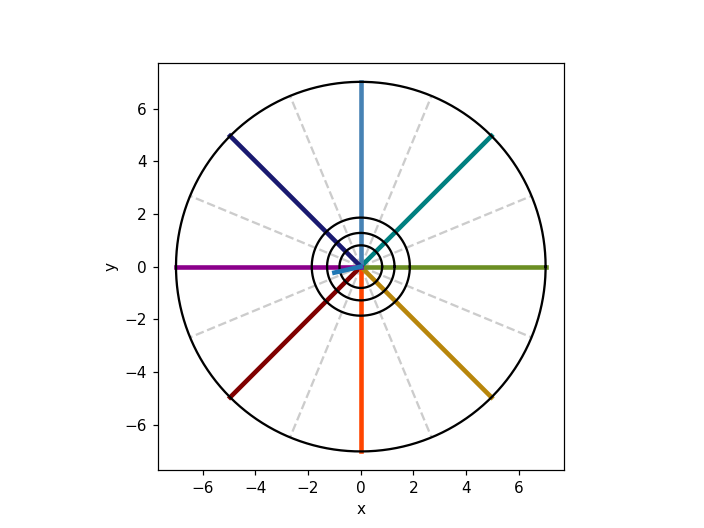

[1. 7.]


In [22]:
#Plot an individual command to confirm the binning!  : 
i = 13500
x = df['u_vx'][i]
y = df['u_vy'][i]

plt.figure()
plot_command_bin()
plt.plot([0,x], [0,y],linewidth=3)
print(bin_r[i])

In [40]:
target_color

['maroon',
 'orangered',
 'darkgoldenrod',
 'olivedrab',
 'teal',
 'steelblue',
 'midnightblue',
 'darkmagenta']

<IPython.core.display.Javascript object>


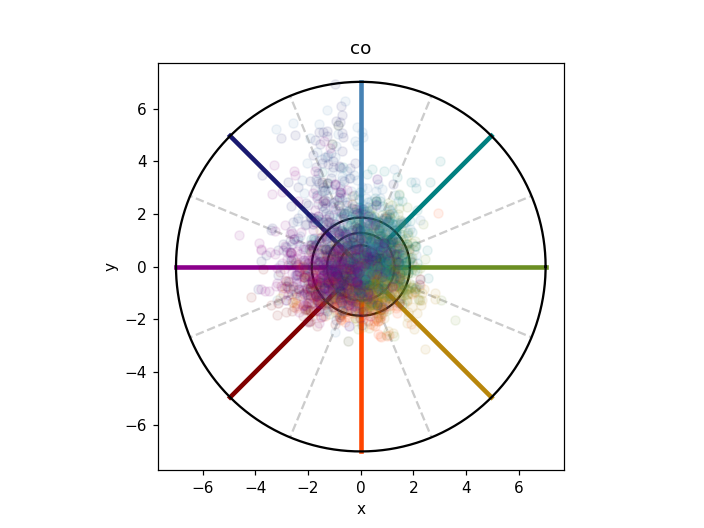

<IPython.core.display.Javascript object>


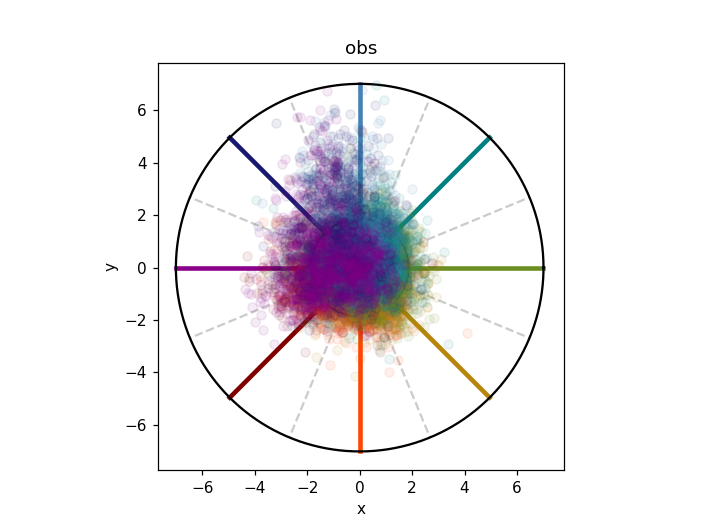

Text(0,0.5,'y')

In [23]:
i = 10
for task in range(num_tasks):
    plt.figure()
    plt.title(task_list[task])    
    plot_command_bin()
    for target in range(num_targets):
            task_sel = (df['task'] == task)
            target_sel = (df['target'] == target)
            sel = task_sel & target_sel
            
            x = df['u_vx'][sel]
            y = df['u_vy'][sel]
            plt.scatter(x, y,alpha=0.08,color=target_color[target],zorder=1000)

plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

<IPython.core.display.Javascript object>


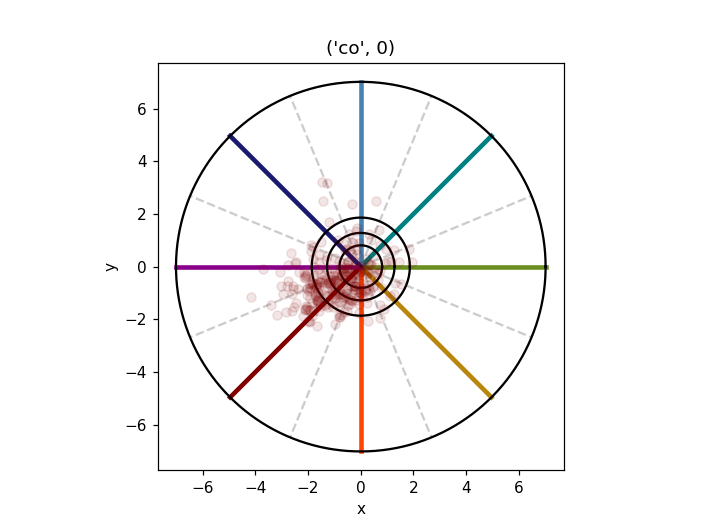

<IPython.core.display.Javascript object>


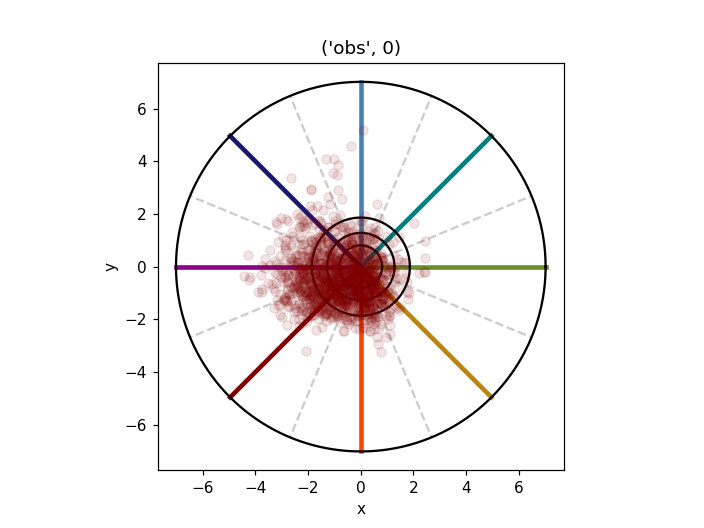

<IPython.core.display.Javascript object>


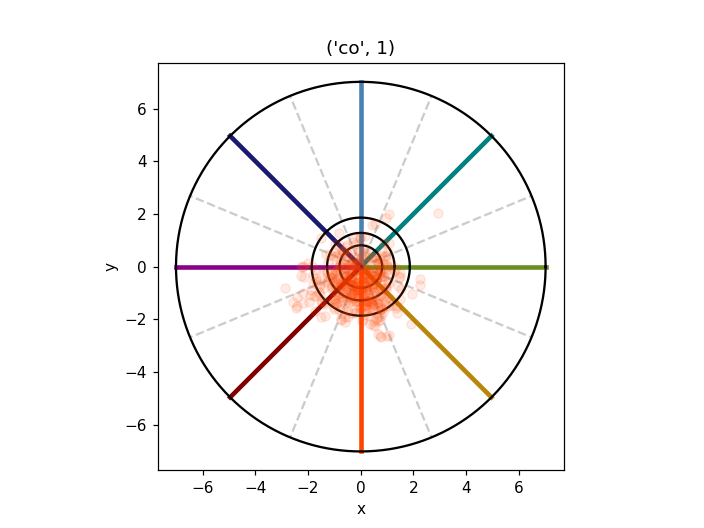

<IPython.core.display.Javascript object>


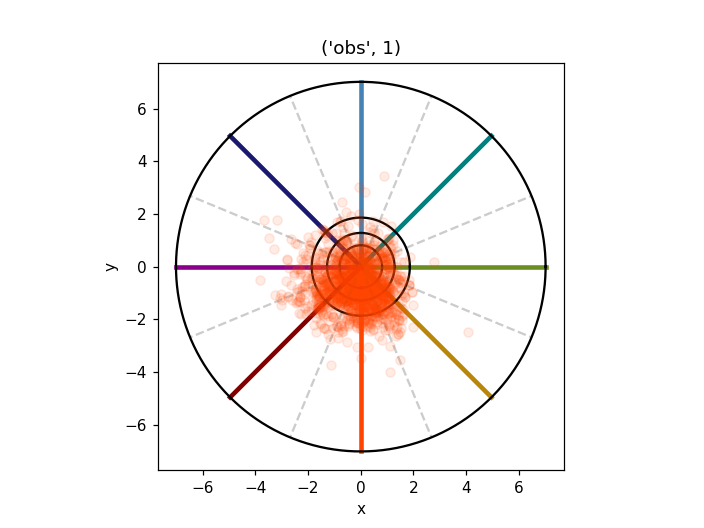

<IPython.core.display.Javascript object>


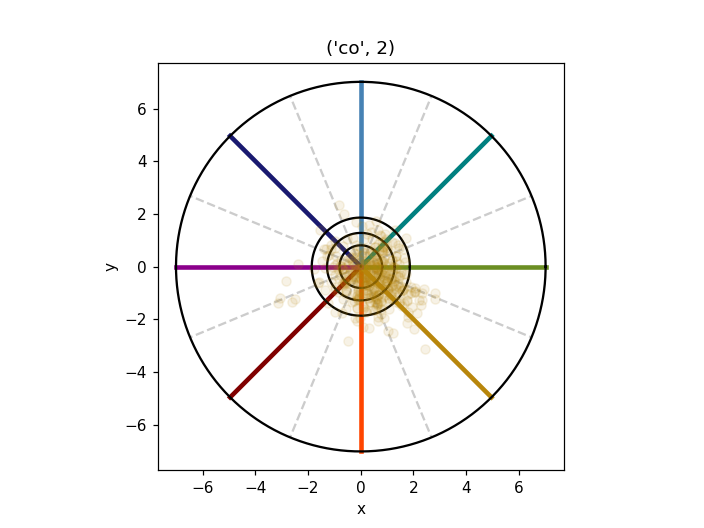

<IPython.core.display.Javascript object>


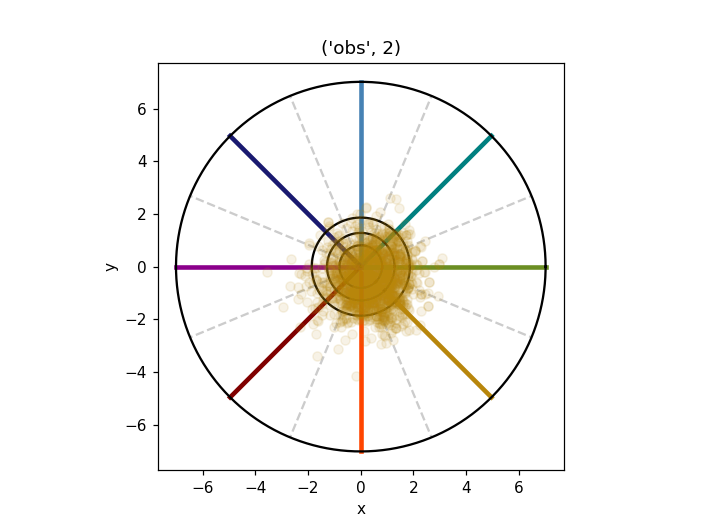

<IPython.core.display.Javascript object>


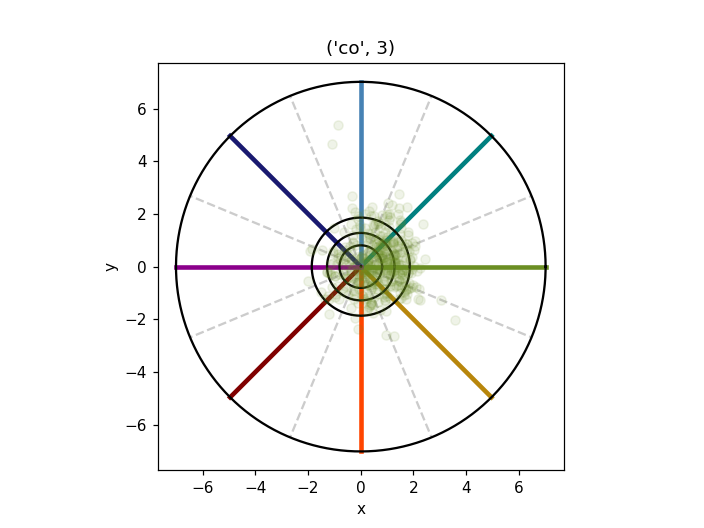

<IPython.core.display.Javascript object>


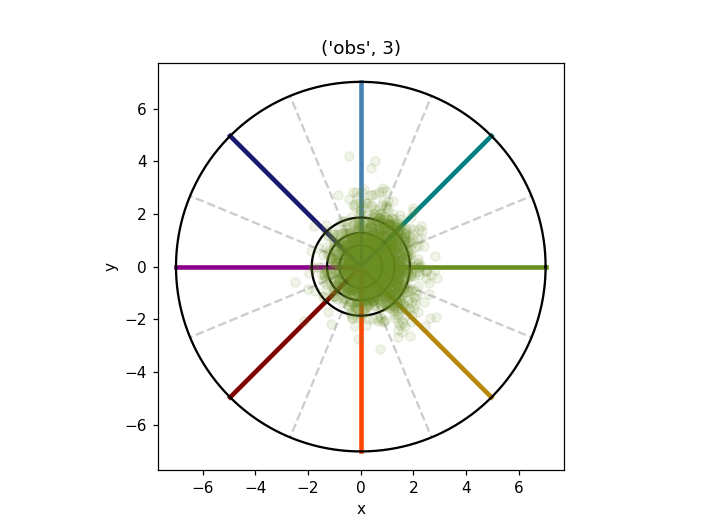

<IPython.core.display.Javascript object>


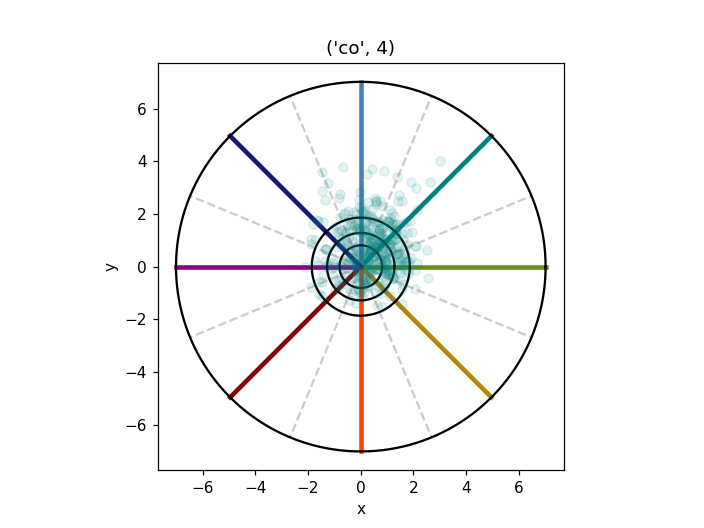

<IPython.core.display.Javascript object>


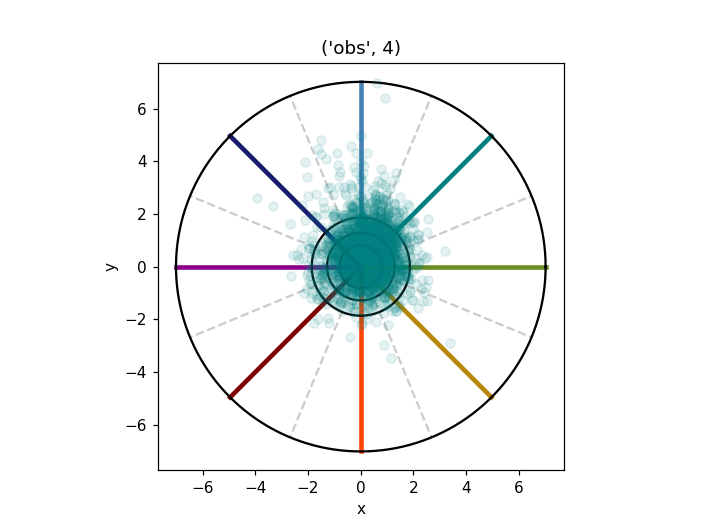

<IPython.core.display.Javascript object>


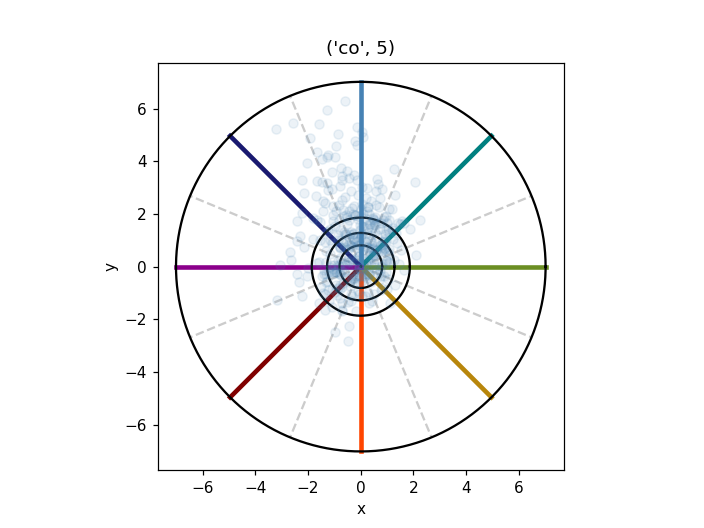

<IPython.core.display.Javascript object>


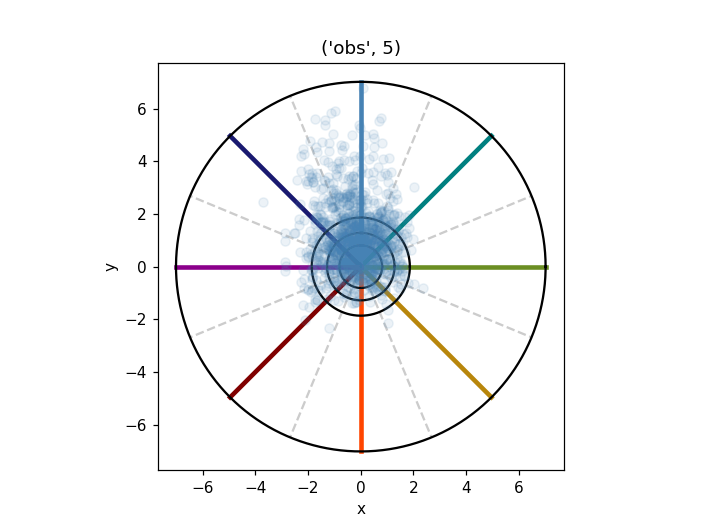

<IPython.core.display.Javascript object>


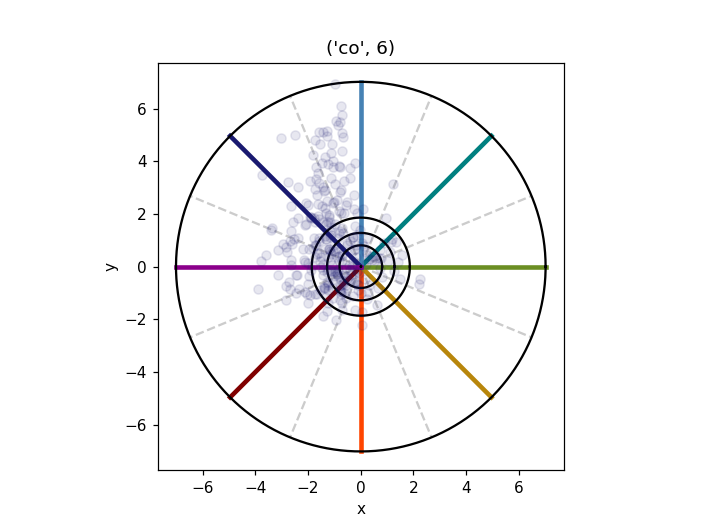

<IPython.core.display.Javascript object>


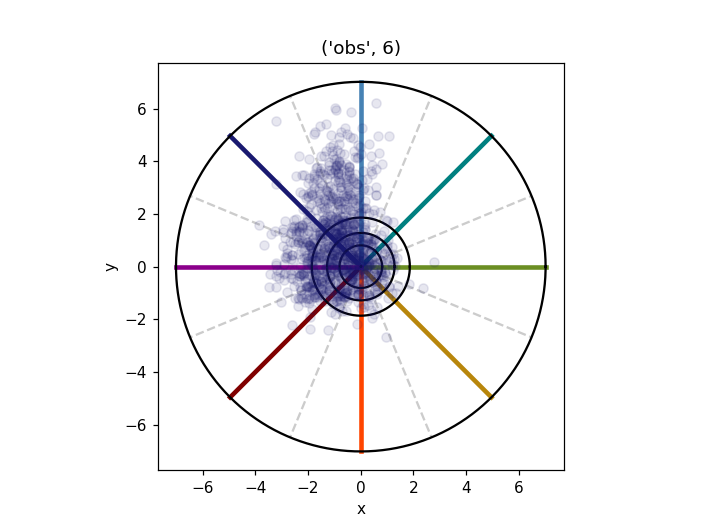

<IPython.core.display.Javascript object>


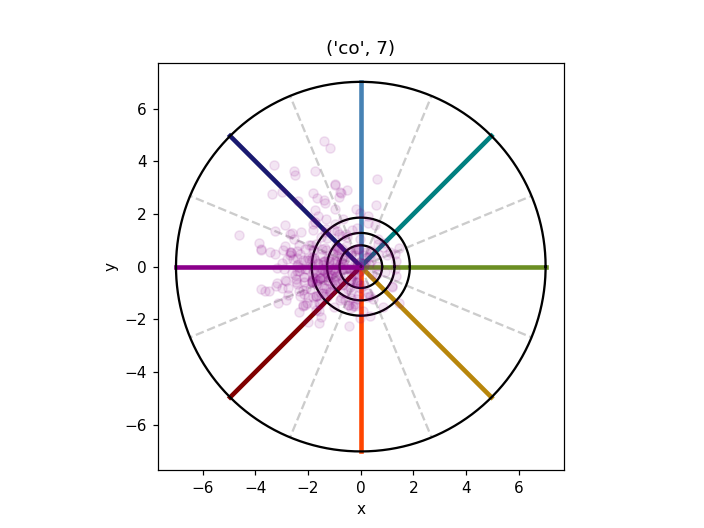

<IPython.core.display.Javascript object>


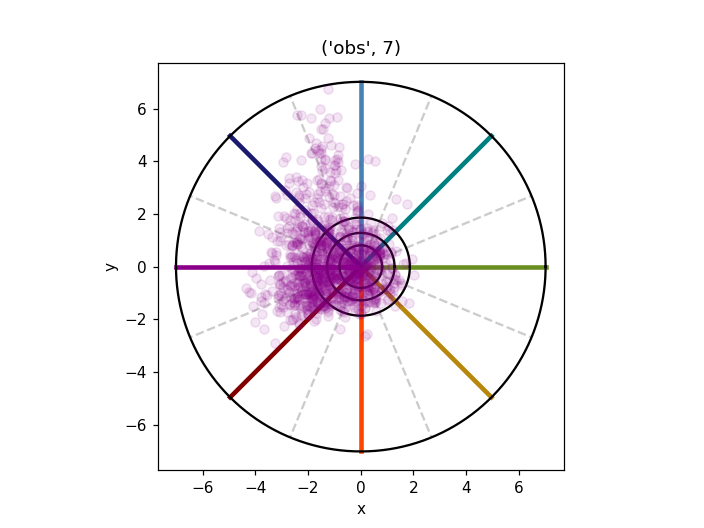

Text(0,0.5,'y')

In [24]:
for target in range(num_targets): #[0]
    for task in range(num_tasks):
        plt.figure()
        plt.title((task_list[task], target))    
        plot_command_bin()        
        
        task_sel = (df['task'] == task)
        target_sel = (df['target'] == target)
        sel = task_sel & target_sel

        x = df['u_vx'][sel]
        y = df['u_vy'][sel]
        plt.scatter(x, y,alpha=0.1,color=target_color[target])

plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

In [87]:
np.where(df.columns=='prog')

(array([79], dtype=int64),)

In [28]:
#early middle late scatter plot
num_phases = 3
phases = np.linspace(0,1,num_phases+1)
trial_phase = np.array([phases[0:-1],phases[1:]])
# trial_phase = np.array([[0, 0.2, 0.6], [0.2, 0.6, 1]])
# trial_phase = np.array([[0, 0.33, 0.66], [0.33, 0.66, 1]])
trial_phase

array([[0.        , 0.33333333, 0.66666667],
       [0.33333333, 0.66666667, 1.        ]])

<IPython.core.display.Javascript object>


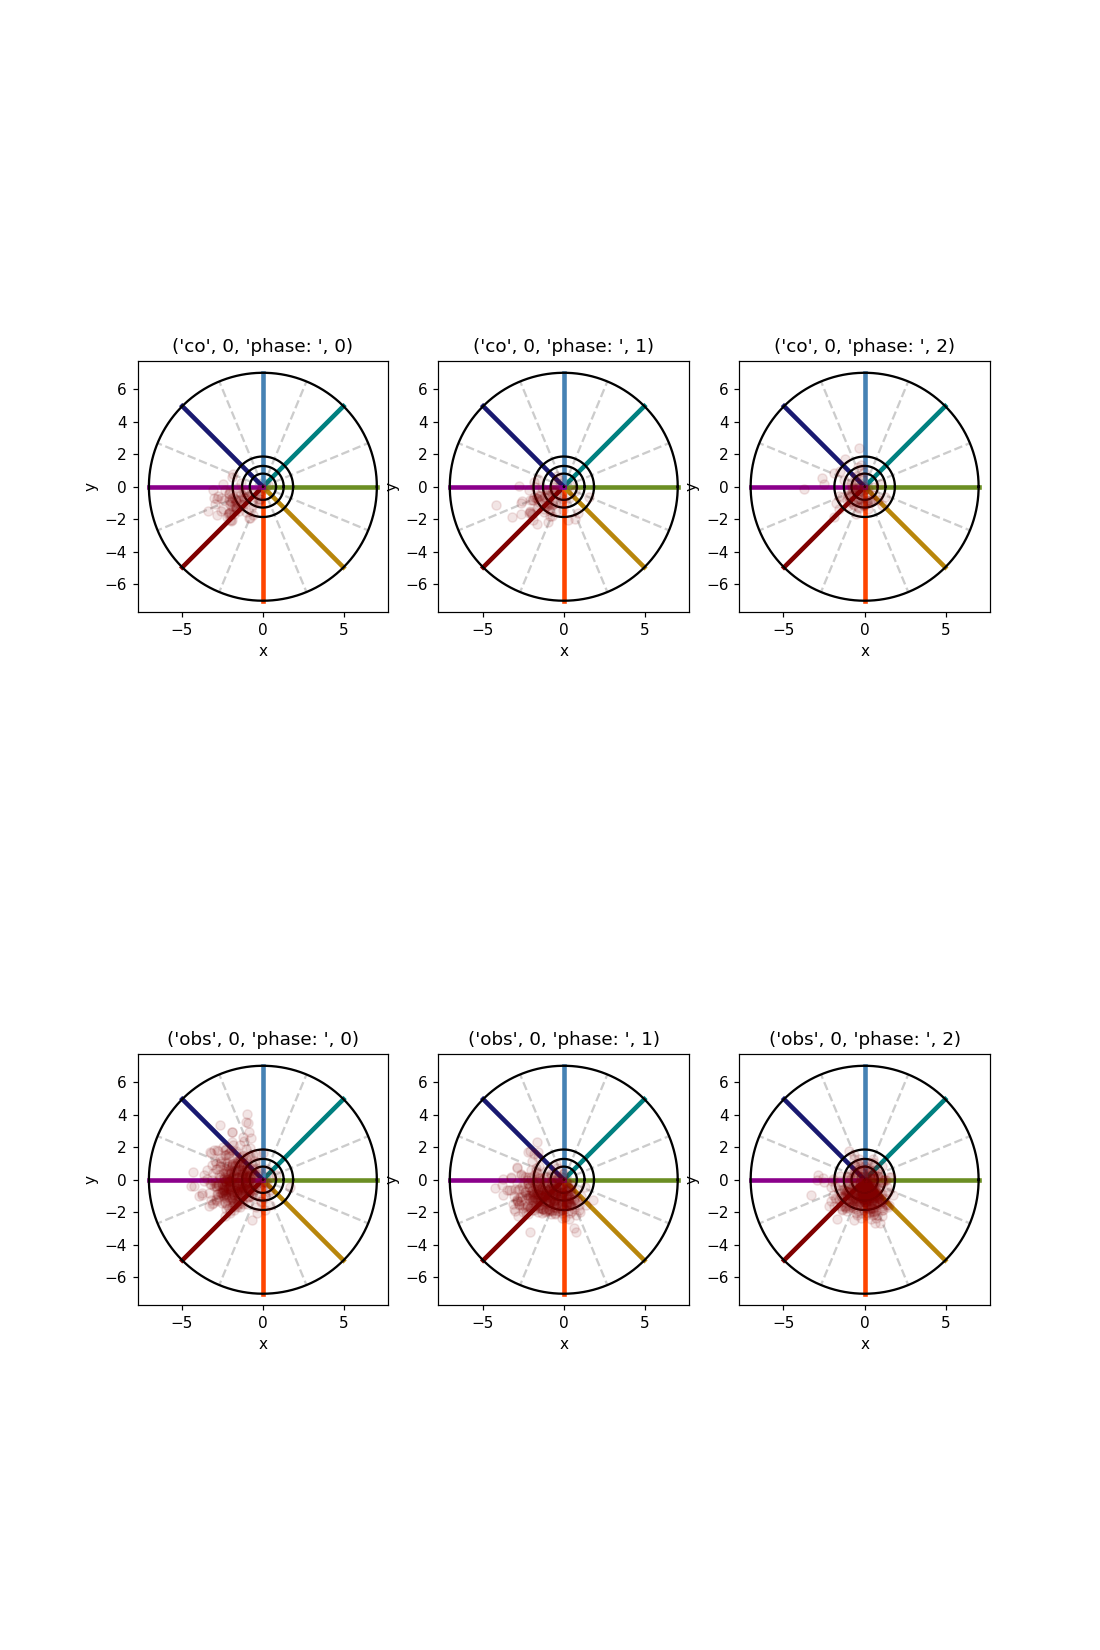

Text(0,0.5,'y')

In [133]:
phase_color = ['g', 'b', 'r'] #maroon
for target in [0]: #range(num_targets): #[0]
    plt.figure(figsize=(10,15))
    for task in range(num_tasks):
        for phase in range(num_phases):
            plt.subplot(2,3,np.ravel_multi_index((task,phase), (2,3))+1)
            plot_command_bin() 
            plt.title((task_list[task], target, 'phase: ', phase))
            
                 
            task_sel = (df['task'] == task)
            target_sel = (df['target'] == target)
            phase_sel = (df['prog'] >= trial_phase[0,phase]) & (df['prog'] <= trial_phase[1,phase])
            sel = task_sel & target_sel & phase_sel

            x = df['u_vx'][sel]
            y = df['u_vy'][sel]
            plt.scatter(x, y,alpha=0.1,color=target_color[target])
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

<IPython.core.display.Javascript object>


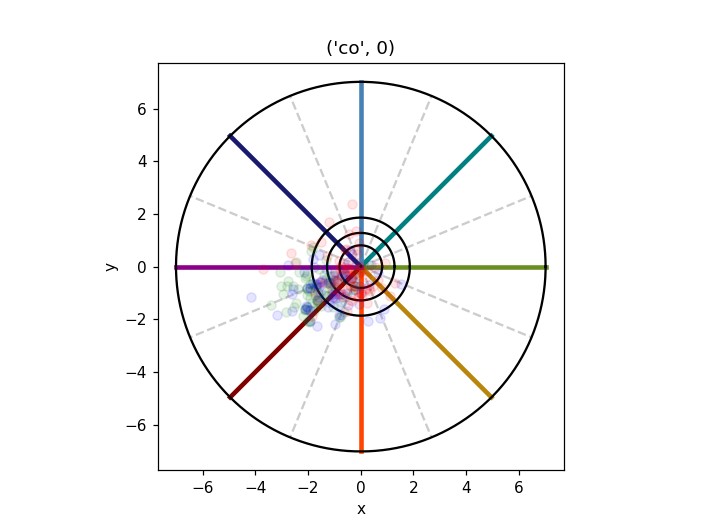

<IPython.core.display.Javascript object>


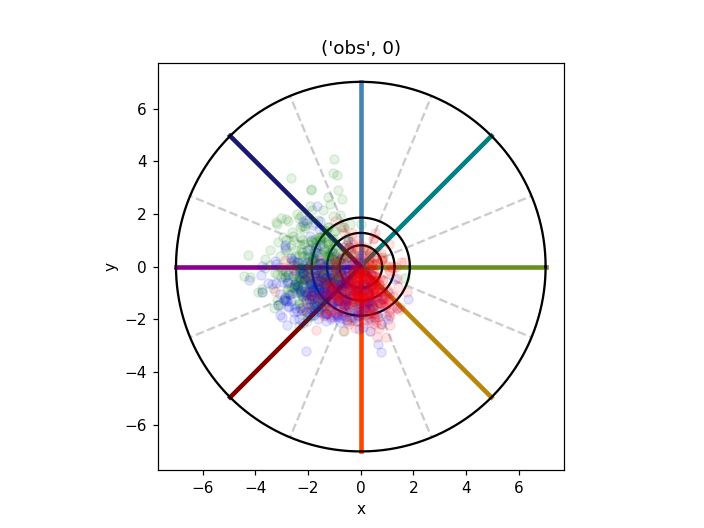

Text(0,0.5,'y')

In [125]:
phase_color = ['g', 'b', 'r'] #maroon
for target in [0]: #range(num_targets): #[0]
#     plt.subplot(2,3,)
    for task in range(num_tasks):
        plt.figure()
        plot_command_bin()   
        plt.title((task_list[task], target))    
        for phase in range(num_phases):
#             plt.title((task_list[task], target, 'phase: ', phase))    
                 
            task_sel = (df['task'] == task)
            target_sel = (df['target'] == target)
            phase_sel = (df['prog'] >= trial_phase[0,phase]) & (df['prog'] <= trial_phase[1,phase])
            sel = task_sel & target_sel & phase_sel

            x = df['u_vx'][sel]
            y = df['u_vy'][sel]
            plt.scatter(x, y,alpha=0.1,color=phase_color[phase])
# phase_color[phase])#target_color[target])
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

### ANALYSIS

In [25]:
list(df.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'task',
 'tc',
 'target',
 'trial',
 'bin',
 'trial_start',
 'trial_stop',
 'target_size',
 'obs_size',
 'bin_end',
 'prog',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 'u_v_mag',
 'u_v_angle',
 'p_angle_ctr',
 'v_angle_ctr',
 'u_p_angle_ctr',
 'u_v_angle_ctr',
 'd2target',
 'x_error',
 'y_error',
 'u_v_mag_bin',
 'u_v_angle_bin']

### DEV: Update code for within-movement analysis

#0) make dedicated code to compare within movement
#FUTURE:
#1) let's update code so all movements are compared, not just across task
#2) if within movement is to be compared, split data into two parts randomly

calc_command_trials_dic_da is good, it gives us all the trials in a data array, we can use that.
Split trials into two halves.
On each half, calc_command_psth
Write new code like: 
calc_command_triggered_psth_diff_at_lag_across_task
#calc_command_psth_diff_within_movement

--
A)
1)
write 'calc_command_psth_incl_within_movement'
this saves psth, (psth, 0), (psth, 1) (trials,0), (trials,1)
as we loop through condition, we construct each of these 

2) 
write 'calc_command_triggered_psth_diff_at_lag'
to compare all movements
and if it compares to itself, use the splits



In [83]:
min_trials = 5
win = [0,1] #[0, 1]
num_win = win[1]-win[0]+1
num_var = len(list(df.columns))
psth_var = ['u_vx', 'u_vy']

task_target_bin_dic=bmi_b.calc_command_trials_dic_da(df, win, num_var, num_tasks, num_targets, num_mag_bins, num_angle_bins)


(0, 0, 0, 0, 10)
(0, 0, 0, 1, 6)
(0, 0, 0, 2, 3)
(0, 0, 0, 3, 3)
(0, 0, 0, 4, 0)
(0, 0, 0, 5, 1)
(0, 0, 0, 6, 2)
(0, 0, 0, 7, 9)
(0, 0, 1, 0, 14)
(0, 0, 1, 1, 12)
(0, 0, 1, 2, 3)
(0, 0, 1, 3, 1)
(0, 0, 1, 4, 0)
(0, 0, 1, 5, 1)
(0, 0, 1, 6, 2)
(0, 0, 1, 7, 4)
(0, 0, 2, 0, 28)
(0, 0, 2, 1, 6)
(0, 0, 2, 2, 3)
(0, 0, 2, 3, 0)
(0, 0, 2, 4, 0)
(0, 0, 2, 5, 2)
(0, 0, 2, 6, 1)
(0, 0, 2, 7, 14)
(0, 0, 3, 0, 45)
(0, 0, 3, 1, 3)
(0, 0, 3, 2, 0)
(0, 0, 3, 3, 0)
(0, 0, 3, 4, 0)
(0, 0, 3, 5, 1)
(0, 0, 3, 6, 3)
(0, 0, 3, 7, 26)
(0, 1, 0, 0, 18)
(0, 1, 0, 1, 16)
(0, 1, 0, 2, 24)
(0, 1, 0, 3, 10)
(0, 1, 0, 4, 5)
(0, 1, 0, 5, 8)
(0, 1, 0, 6, 8)
(0, 1, 0, 7, 10)
(0, 1, 1, 0, 23)
(0, 1, 1, 1, 32)
(0, 1, 1, 2, 16)
(0, 1, 1, 3, 6)
(0, 1, 1, 4, 1)
(0, 1, 1, 5, 3)
(0, 1, 1, 6, 5)
(0, 1, 1, 7, 11)
(0, 1, 2, 0, 16)
(0, 1, 2, 1, 38)
(0, 1, 2, 2, 18)
(0, 1, 2, 3, 1)
(0, 1, 2, 4, 0)
(0, 1, 2, 5, 1)
(0, 1, 2, 6, 0)
(0, 1, 2, 7, 7)
(0, 1, 3, 0, 19)
(0, 1, 3, 1, 20)
(0, 1, 3, 2, 8)
(0, 1, 3, 3, 0)
(0, 1, 3, 4, 0)
(0,

(1, 7, 2, 6, 36)
(1, 7, 2, 7, 69)
(1, 7, 3, 0, 119)
(1, 7, 3, 1, 2)
(1, 7, 3, 2, 0)
(1, 7, 3, 3, 1)
(1, 7, 3, 4, 0)
(1, 7, 3, 5, 61)
(1, 7, 3, 6, 114)
(1, 7, 3, 7, 157)


In [84]:
bmi_b.calc_command_psth(task_target_bin_dic, psth_var, min_trials, num_tasks, num_targets, num_mag_bins, num_angle_bins)

In [85]:
#INSPECT:
print(task_target_bin_dic[0,0,0,0,'num'])
print(task_target_bin_dic[0,0,0,0,'psth_trials',0])
print(task_target_bin_dic[0,0,0,0,'psth_trials',1])

psth0 = task_target_bin_dic[0,0,0,0,'psth',0]
psth1 = task_target_bin_dic[0,0,0,0,'psth',1]
print(psth0)
print(psth1)

10
[0 3 6 8 9]
[1 2 4 5 7]
<xarray.DataArray (var: 2, time: 2)>
array([[-0.268388, -1.340634],
       [-0.302909, -0.321703]])
Coordinates:
  * var      (var) |S13 'u_vx' 'u_vy'
  * time     (time) int32 0 1
<xarray.DataArray (var: 2, time: 2)>
array([[-0.36361 , -0.733368],
       [-0.332849, -0.841707]])
Coordinates:
  * var      (var) |S13 'u_vx' 'u_vy'
  * time     (time) int32 0 1


In [170]:
#Takes a lot of time ... 
lags = [0,1]
min_trials = 5

t_start = timeit.default_timer()
diff_df = bmi_b.calc_command_triggered_psth_diff_at_lag(lags, task_target_bin_dic, min_trials, num_mag_bins, num_angle_bins, num_targets, num_tasks)
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)

(0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 0, 2)
(0, 0, 0, 3)
(0, 0, 0, 4)
(0, 0, 0, 5)
(0, 0, 0, 6)
(0, 0, 0, 7)
(0, 1, 0, 1)
(0, 1, 0, 2)
(0, 1, 0, 3)
(0, 1, 0, 4)
(0, 1, 0, 5)
(0, 1, 0, 6)
(0, 1, 0, 7)
(0, 2, 0, 2)
(0, 2, 0, 3)
(0, 2, 0, 4)
(0, 2, 0, 5)
(0, 2, 0, 6)
(0, 2, 0, 7)
(0, 3, 0, 3)
(0, 3, 0, 4)
(0, 3, 0, 5)
(0, 3, 0, 6)
(0, 3, 0, 7)
(0, 4, 0, 4)
(0, 4, 0, 5)
(0, 4, 0, 6)
(0, 4, 0, 7)
(0, 5, 0, 5)
(0, 5, 0, 6)
(0, 5, 0, 7)
(0, 6, 0, 6)
(0, 6, 0, 7)
(0, 7, 0, 7)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 0, 1, 2)
(0, 0, 1, 3)
(0, 0, 1, 4)
(0, 0, 1, 5)
(0, 0, 1, 6)
(0, 0, 1, 7)
(0, 1, 1, 0)
(0, 1, 1, 1)
(0, 1, 1, 2)
(0, 1, 1, 3)
(0, 1, 1, 4)
(0, 1, 1, 5)
(0, 1, 1, 6)
(0, 1, 1, 7)
(0, 2, 1, 0)
(0, 2, 1, 1)
(0, 2, 1, 2)
(0, 2, 1, 3)
(0, 2, 1, 4)
(0, 2, 1, 5)
(0, 2, 1, 6)
(0, 2, 1, 7)
(0, 3, 1, 0)
(0, 3, 1, 1)
(0, 3, 1, 2)
(0, 3, 1, 3)
(0, 3, 1, 4)
(0, 3, 1, 5)
(0, 3, 1, 6)
(0, 3, 1, 7)
(0, 4, 1, 0)
(0, 4, 1, 1)
(0, 4, 1, 2)
(0, 4, 1, 3)
(0, 4, 1, 4)
(0, 4, 1, 5)
(0, 4, 1, 6)
(0, 4, 1, 7)
(0, 5, 1, 0)

In [171]:
task0_sel = 1
task1_sel = 1
target0_sel = 1
target1_sel = 2
bm_sel = 1
ba_sel = 1
l_sel = 1

sel = (diff_df['task0']==task0_sel)\
&(diff_df['task1']==task1_sel)\
&(diff_df['target0']==target0_sel)\
&(diff_df['target1']==target1_sel)\
&(diff_df['target0']==target0_sel)\
&(diff_df['lag']==l_sel)\
&(diff_df['mag_bin_current']==bm_sel)\
&(diff_df['angle_bin_current']==ba_sel)


diff_df[sel]#np.where(sel)

diff_mag  diff_angle  diff_mag_abs  diff_angle_abs  diff_norm    diff_x  \
2617 -0.003755    0.214409      0.003755        0.214409   0.199773 -0.197409   

        diff_y  lag  mag_bin_current  angle_bin_current  task0  target0  \
2617 -0.030645    1                1                  1      1        1   

      num_trials0     u_vx0     u_vy0  task1  target1  num_trials1     u_vx1  \
2617           83  0.060958 -0.929489      1        2          110  0.258366   

         u_vy1  
2617 -0.898844

In [172]:
task0_sel = 1
task1_sel = 1
target0_sel = 2
target1_sel = 1
bm_sel = 1
ba_sel = 1
l_sel = 1

sel = (diff_df['task0']==task0_sel)\
&(diff_df['task1']==task1_sel)\
&(diff_df['target0']==target0_sel)\
&(diff_df['target1']==target1_sel)\
&(diff_df['target0']==target0_sel)\
&(diff_df['lag']==l_sel)\
&(diff_df['mag_bin_current']==bm_sel)\
&(diff_df['angle_bin_current']==ba_sel)

diff_df[sel]#np.where(sel)

Empty DataFrame
Columns: [diff_mag, diff_angle, diff_mag_abs, diff_angle_abs, diff_norm, diff_x, diff_y, lag, mag_bin_current, angle_bin_current, task0, target0, num_trials0, u_vx0, u_vy0, task1, target1, num_trials1, u_vx1, u_vy1]
Index: []

In [235]:
#accumulate the differences: 
l=1
min_trials_analyze = 15
max_mag=3

#sel: 
lag_sel = (diff_df['lag']==l)
num_trials0_sel = (diff_df['num_trials0']>=min_trials_analyze) #5
num_trials1_sel = (diff_df['num_trials1']>=min_trials_analyze) #5
mag_sel = (diff_df['mag_bin_current']<=max_mag)

sel_universal = lag_sel\
    &num_trials0_sel\
    &num_trials1_sel\
    &mag_sel

move_sel_dic = {}
move_list = ['within_move', 'within_task', 'within_co', 'within_obs', 'across_task', 'across_move']
move_sel_dic['within_move', 'sel'] = (diff_df['target0']==diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
move_sel_dic['within_task', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
move_sel_dic['within_co', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==0)
move_sel_dic['within_obs', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==1)
move_sel_dic['across_task', 'sel'] = (diff_df['task0']!=diff_df['task1'])
move_sel_dic['across_move', 'sel'] = (diff_df['task0']!=diff_df['task1'])|(diff_df['target0']!=diff_df['target1'])

for move in move_list: 
    sel = sel_universal\
    &move_sel_dic[move,'sel']
    move_sel_dic[move, 'diff_mag_abs'] = diff_df['diff_mag_abs'][sel]
    move_sel_dic[move, 'diff_angle_abs'] = diff_df['diff_angle_abs'][sel]
    move_sel_dic[move, 'diff_norm'] = np.array(diff_df['diff_norm'][sel])
    
    

In [281]:
num_bins = 30
diff_bins = np.linspace(0,3,num_bins)
bin_edges = np.array([diff_bins[:-1], diff_bins[1:]])
bin_dic = {0:bin_edges}                     

for move in move_list: 
    d = move_sel_dic[move, 'diff_norm']
    br, hr = bmi_b.bin_vec_data(d.reshape(-1,1), bin_dic)
    pmf = hr/np.sum(hr)
    cmf = np.cumsum(pmf)
    move_sel_dic[move, 'hist'] = hr
    move_sel_dic[move, 'pmf'] = pmf
    move_sel_dic[move, 'cmf'] = cmf

In [287]:
min_trials_analyze

15

<IPython.core.display.Javascript object>


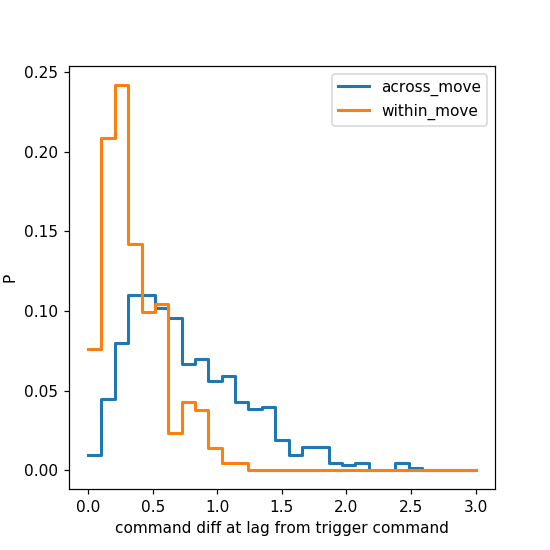

<IPython.core.display.Javascript object>


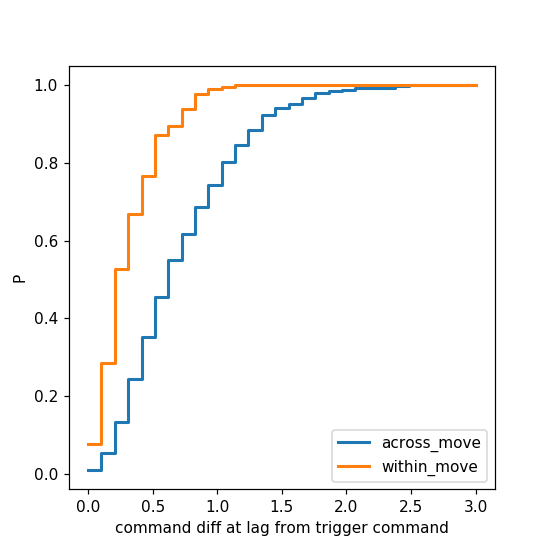

In [288]:
save_bool = True
ext_list = ['.png','.eps']
title_str = 'command_diff_at_lag_within_vs_across_move_STAIR'
move_plot =  ['across_move', 'within_move']
d_plot = ['pmf', 'cmf']

for var in d_plot:
    plt.figure(figsize=(5,5))
    for move in move_plot: 
        d = move_sel_dic[move,var]
        bmi_b.plot_hist_stair(bin_edges, d, label=move) 
    plt.legend()
    plt.xlabel('command diff at lag from trigger command')
    plt.ylabel('P')
    if save_bool: 
        for ext in ext_list:
            save_path = os.path.join(save_dir, title_str+'_'+var+'_obs'+str(min_trials_analyze)+ext)
            plt.savefig(save_path)
        

<IPython.core.display.Javascript object>


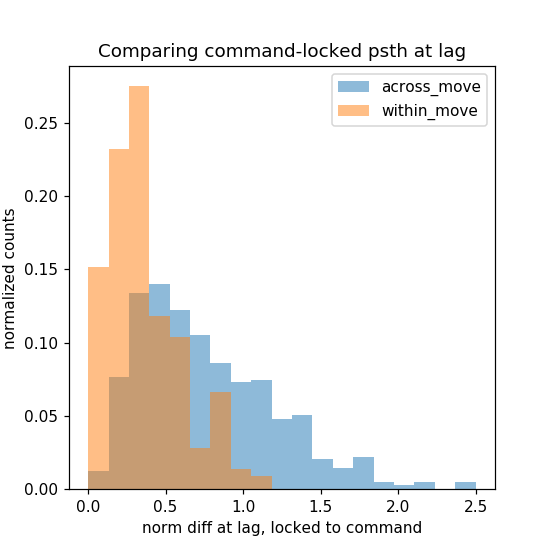

In [289]:
save_bool = False
ext_list = ['.png','.eps']
move_plot =  ['across_move', 'within_move']
#['across_move', 'within_obs', 'within_co', 'within_move']
title_str = 'command_psth_diff'

bins = np.linspace(0,2.5,20)
plt.figure(figsize=(5,5))
for move in move_plot: 
    d = move_sel_dic[move, 'diff_norm']
    
    plt.hist(d, bins, weights=np.ones_like(d)/len(d), alpha=0.5, label=move)

plt.legend()
plt.xlabel('norm diff at lag, locked to command')
plt.ylabel('normalized counts')
plt.title('Comparing command-locked psth at lag')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, title_str+'_obs'+str(min_trials_analyze)+ext)
        plt.savefig(save_path)

In [292]:
title_str

'command_psth_diff'

<IPython.core.display.Javascript object>


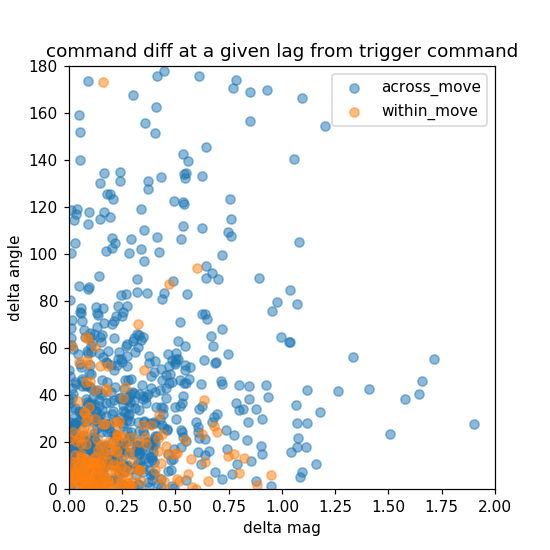

('across_move', 'num samples', 628)
('within_move', 'num samples', 211)


In [293]:
save_bool = True
ext_list = ['.png','.eps']

title_str = 'scatter_mag_angle_command_diff_at_lag'

move_plot = ['across_move', 'within_move']
plt.figure(figsize=(5,5))
for move in move_plot:
    x = move_sel_dic[move, 'diff_mag_abs']
    y = move_sel_dic[move, 'diff_angle_abs']*180/np.pi
    plt.scatter(x,y,alpha=0.5,label=move)
    print(move, 'num samples', len(x))

plt.legend()
plt.ylabel('delta angle')
plt.xlabel('delta mag')
plt.title('command diff at a given lag from trigger command')
plt.ylim(0,180)
plt.xlim(0,2)

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, title_str+'_obs'+str(min_trials_analyze)+ext)
        plt.savefig(save_path)


<IPython.core.display.Javascript object>


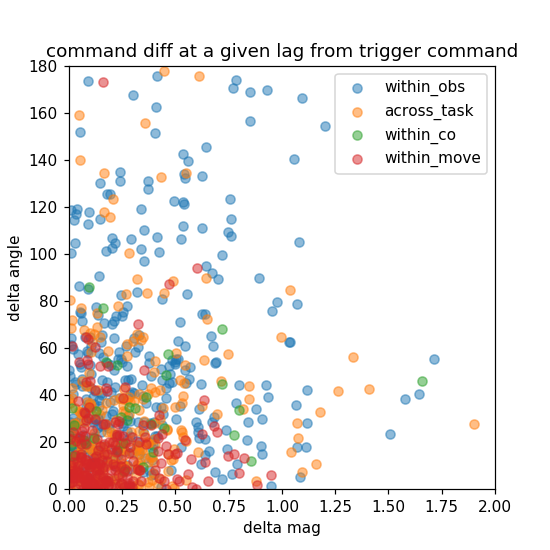

('within_obs', 'num samples', 340)
('across_task', 'num samples', 255)
('within_co', 'num samples', 33)
('within_move', 'num samples', 211)


In [295]:
save_bool = True
ext_list = ['.png','.eps']

title_str = 'scatter_mag_angle_command_diff_at_lag_ALL_compare'

move_plot = ['within_obs', 'across_task', 'within_co', 'within_move']
plt.figure(figsize=(5,5))
for move in move_plot:
    x = move_sel_dic[move, 'diff_mag_abs']
    y = move_sel_dic[move, 'diff_angle_abs']*180/np.pi
    plt.scatter(x,y,alpha=0.5,label=move)
    print(move, 'num samples', len(x))

plt.legend()
plt.ylabel('delta angle')
plt.xlabel('delta mag')
plt.title('command diff at a given lag from trigger command')
plt.ylim(0,180)
plt.xlim(0,2)

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, title_str+'_obs'+str(min_trials_analyze)+ext)
        plt.savefig(save_path)


<IPython.core.display.Javascript object>


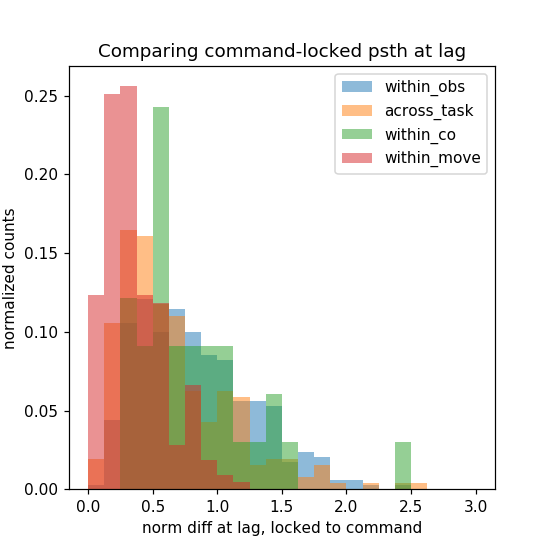

In [301]:
save_bool = True
ext_list = ['.png','.eps']
move_plot = ['within_obs', 'across_task', 'within_co', 'within_move']
title_str = 'hist_mag_angle_command_diff_at_lag_ALL_compare'



title_str = 'command_diff_hist_compare_ALL'

bins = np.linspace(0,3,25)
plt.figure(figsize=(5,5))
for move in move_plot: 
    d = move_sel_dic[move, 'diff_norm']
    
    plt.hist(d, bins, weights=np.ones_like(d)/len(d), alpha=0.5, label=move)

plt.legend()
plt.xlabel('norm diff at lag, locked to command')
plt.ylabel('normalized counts')
plt.title('Comparing command-locked psth at lag')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, title_str+'_obs'+str(min_trials_analyze)+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


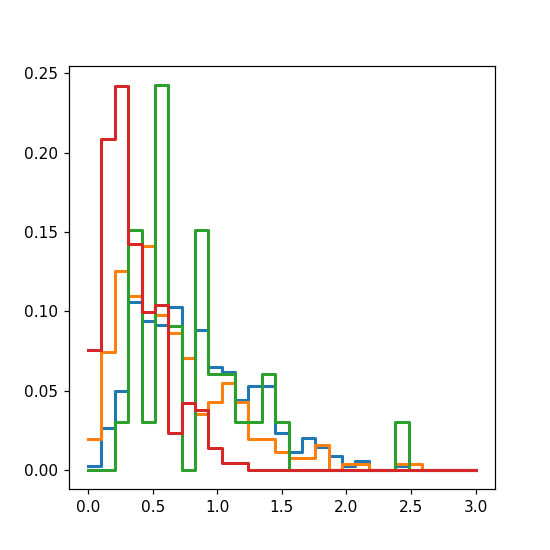

<IPython.core.display.Javascript object>


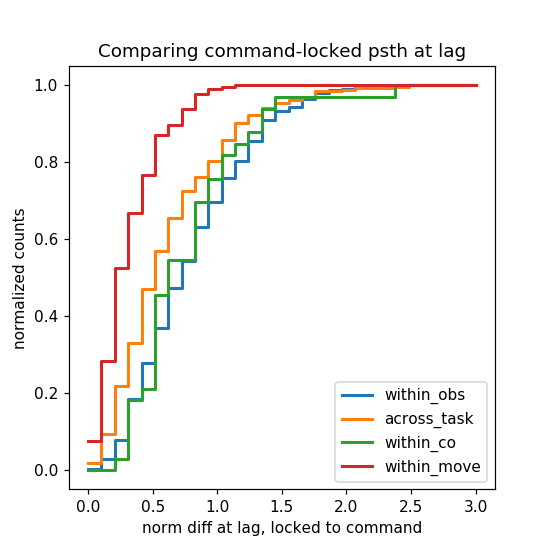

In [305]:
save_bool = True
ext_list = ['.png','.eps']
move_plot = ['within_obs', 'across_task', 'within_co', 'within_move']
# title_str = 'hist_mag_angle_command_diff_at_lag_ALL_compare'
title_str = 'command_diff_at_lag_compare_ALL_STAIR'

bins = np.linspace(0,3,25)

for var in d_plot:
    plt.figure(figsize=(5,5))
    for move in move_plot: 
            d = move_sel_dic[move,var]
            bmi_b.plot_hist_stair(bin_edges, d, label=move)

plt.legend()
plt.xlabel('norm diff at lag, locked to command')
plt.ylabel('normalized counts')
plt.title('Comparing command-locked psth at lag')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, title_str+'_obs'+str(min_trials_analyze)+ext)
        plt.savefig(save_path)

In [ ]:
save_bool = True
ext_list = ['.png','.eps']
title_str = 'command_diff_at_lag_within_vs_across_move_STAIR'
move_plot =  ['across_move', 'within_move']
d_plot = ['pmf', 'cmf']

for var in d_plot:
    plt.figure(figsize=(5,5))
    for move in move_plot: 
        d = move_sel_dic[move,var]
        bmi_b.plot_hist_stair(bin_edges, d, label=move) 
    plt.legend()
    plt.xlabel('command diff at lag from trigger command')
    plt.ylabel('P')
    if save_bool: 
        for ext in ext_list:
            save_path = os.path.join(save_dir, title_str+'_'+var+'_obs'+str(min_trials_analyze)+ext)
            plt.savefig(save_path)
        

In [129]:
diff_df.head()

diff_mag  diff_angle    diff_x    diff_y  lag  mag_bin_current  \
0 -0.088246   -0.104491  0.095222  0.029940    0                0   
1  0.262315    0.618563 -0.607266  0.520003    1                0   
2 -0.103341    0.033649  0.059476  0.086150    0                0   
3  0.100355    0.352659 -0.329918  0.246069    1                0   
4 -0.156505    0.009658  0.106175  0.115091    0                0   

   angle_bin_current  task0  target0  num_trials0     u_vx0     u_vy0  task1  \
0                  0      0        0           10 -0.268388 -0.302909      0   
1                  0      0        0           10 -1.340634 -0.321703      0   
2                  0      0        0           10 -0.315999 -0.317879      1   
3                  0      0        0           10 -1.037001 -0.581705      1   
4                  0      0        0           10 -0.315999 -0.317879      0   

   target1  num_trials1     u_vx1     u_vy1  
0        0           10 -0.363610 -0.332849  
1        0           10 -0.733368 -0.841707  
2        0           32 -0.375475 -0.404029  
3        0           32 -0.707083 -0.827774  
4        1           18 -0.422174 -0.432970

### DEV: Scatter the diff in angle and movement: 

In [196]:

min_trials = 5
win = [0,1] #[0, 1]
num_win = win[1]-win[0]+1
num_var = len(list(df.columns))
psth_var = ['u_vx', 'u_vy']

task_target_bin_dic=bmi_b.calc_command_trials_dic_da(df, win, num_var, num_tasks, num_targets, num_mag_bins, num_angle_bins)
bmi_b.calc_command_psth(task_target_bin_dic, psth_var, min_trials, num_tasks, num_targets, num_mag_bins, num_angle_bins)



(0, 0, 0, 0, 8)
(0, 0, 0, 1, 3)
(0, 0, 0, 2, 2)
(0, 0, 0, 3, 3)
(0, 0, 0, 4, 0)
(0, 0, 0, 5, 1)
(0, 0, 0, 6, 2)
(0, 0, 0, 7, 5)
(0, 0, 1, 0, 10)
(0, 0, 1, 1, 7)
(0, 0, 1, 2, 2)
(0, 0, 1, 3, 1)
(0, 0, 1, 4, 0)
(0, 0, 1, 5, 1)
(0, 0, 1, 6, 2)
(0, 0, 1, 7, 3)
(0, 0, 2, 0, 19)
(0, 0, 2, 1, 5)
(0, 0, 2, 2, 2)
(0, 0, 2, 3, 0)
(0, 0, 2, 4, 0)
(0, 0, 2, 5, 2)
(0, 0, 2, 6, 0)
(0, 0, 2, 7, 11)
(0, 0, 3, 0, 29)
(0, 0, 3, 1, 3)
(0, 0, 3, 2, 0)
(0, 0, 3, 3, 0)
(0, 0, 3, 4, 0)
(0, 0, 3, 5, 1)
(0, 0, 3, 6, 1)
(0, 0, 3, 7, 17)
(0, 1, 0, 0, 14)
(0, 1, 0, 1, 14)
(0, 1, 0, 2, 19)
(0, 1, 0, 3, 8)
(0, 1, 0, 4, 4)
(0, 1, 0, 5, 8)
(0, 1, 0, 6, 8)
(0, 1, 0, 7, 5)
(0, 1, 1, 0, 18)
(0, 1, 1, 1, 23)
(0, 1, 1, 2, 14)
(0, 1, 1, 3, 4)
(0, 1, 1, 4, 1)
(0, 1, 1, 5, 3)
(0, 1, 1, 6, 3)
(0, 1, 1, 7, 8)
(0, 1, 2, 0, 9)
(0, 1, 2, 1, 31)
(0, 1, 2, 2, 17)
(0, 1, 2, 3, 1)
(0, 1, 2, 4, 0)
(0, 1, 2, 5, 1)
(0, 1, 2, 6, 0)
(0, 1, 2, 7, 3)
(0, 1, 3, 0, 11)
(0, 1, 3, 1, 17)
(0, 1, 3, 2, 8)
(0, 1, 3, 3, 0)
(0, 1, 3, 4, 0)
(0, 1, 3,

(1, 7, 2, 7, 55)
(1, 7, 3, 0, 96)
(1, 7, 3, 1, 1)
(1, 7, 3, 2, 0)
(1, 7, 3, 3, 1)
(1, 7, 3, 4, 0)
(1, 7, 3, 5, 40)
(1, 7, 3, 6, 72)
(1, 7, 3, 7, 139)


In [206]:
lags = [-5, -1, 0, 1, 5]

#Calc diff of mag and diff of angle: 
columns = ['diff_mag', 'diff_angle', 'diff_x', 'diff_y', 'lag',
           'mag_bin_current', 'angle_bin_current', 
           'task0', 'target0', 'num_trials0', 'u_vx0', 'u_vy0',
           'task1', 'target1', 'num_trials1', 'u_vx1', 'u_vy1']
num_col = len(columns)
nan_df = pd.DataFrame(np.ones((1,num_col))*np.nan, columns=columns)
df_list = []
#Compute:        
for bm in range(num_mag_bins):
    for ba in range(num_angle_bins):
        for t0 in range(num_targets):
            task = 0
            num_trials0 = task_target_bin_dic[task,t0,bm,ba,'num']
            d0_valid = num_trials0 >= min_trials
            if d0_valid: 
                d0 = task_target_bin_dic[task,t0,bm,ba,'psth']            
                for t1 in range(num_targets):
                    task = 1
                    num_trials1= task_target_bin_dic[task,t1,bm,ba,'num']
                    d1_valid = num_trials1 >= min_trials
                    if d1_valid: 
                        d1 = task_target_bin_dic[task,t1,bm,ba,'psth']
#                         psth_diff = d0-d1
                        #loop lags: 
                        for l in lags:
                            #Convert to polar: 
                            x0 = float(d0.loc['u_vx',l])
                            y0 = float(d0.loc['u_vy',l])
                            d0_mag = np.linalg.norm(np.array(d0.loc[:,l]))                            
                            d0_angle = np.arctan2(y0,x0)
                            
                            x1 = float(d1.loc['u_vx',l])
                            y1 = float(d1.loc['u_vy',l])
                            d1_mag = np.linalg.norm(np.array(d1.loc[:,l]))        
                            d1_angle = np.arctan2(y1,x1)
                                                    
                            l_diff_mag = d0_mag-d1_mag
                            l_diff_angle = bmi_b.center_angle_v2(d1_angle-d0_angle, 0)                            
                            
                            #ASSIGN:
                            df_i = copy.copy(nan_df)
                            df_i['diff_mag'] = l_diff_mag
                            df_i['diff_angle'] = l_diff_angle
                            df_i['diff_x'] = float(x0-x1)
                            df_i['diff_y'] = float(y0-y1)
                            df_i['lag'] = l
                            df_i['mag_bin_current'] = bm
                            df_i['angle_bin_current'] = ba
                            
                            df_i['task0'] = 0
                            df_i['target0'] = t0
                            df_i['num_trials0'] = num_trials0
                            df_i['u_vx0'] = x0
                            df_i['u_vy0'] = y0
                            
                            df_i['task1'] = 1
                            df_i['target1'] = t1
                            df_i['num_trials1'] = num_trials1
                            df_i['u_vx1'] = x1
                            df_i['u_vy1'] = y1
                            #APPEND: 
                            df_list.append(df_i)
                            
diff_df = pd.concat(df_list, ignore_index=True)

In [123]:
diff_df.head(10)

diff_mag  diff_angle    diff_x    diff_y  lag  mag_bin_current  \
0  0.374675    2.686572 -0.336553  0.164662   -1                0   
1  0.098937    0.969399  0.055978  0.081578    0                0   
2  0.414930    2.526891 -0.338975  0.239296    1                0   
3  0.707670    2.776137 -0.660936  0.252903   -1                0   
4  0.102519    1.002279  0.055195  0.086393    0                0   
5  0.747332    3.105495 -0.746845  0.026971    1                0   
6  1.076123    3.060415 -1.072579  0.087262   -1                0   
7  0.117236    0.967338  0.066531  0.096530    0                0   
8  1.105699    2.931708 -1.081434  0.230369    1                0   
9  1.012255   -2.881218 -0.978135 -0.260597   -1                0   

   angle_bin_current  task0  target0  num_trials0  task1  target1  num_trials1  
0                  0      0        0            9      1        0           30  
1                  0      0        0            9      1        0           30  
2                  0      0        0            9      1        0           30  
3                  0      0        0            9      1        1           40  
4                  0      0        0            9      1        1           40  
5                  0      0        0            9      1        1           40  
6                  0      0        0            9      1        2           34  
7                  0      0        0            9      1        2           34  
8                  0      0        0            9      1        2           34  
9                  0      0        0            9      1        3           29

('target0:', 7)
('command angle:', 7)
('lag:', -1)
2301   -31.028058
Name: diff_angle, dtype: float64


<IPython.core.display.Javascript object>


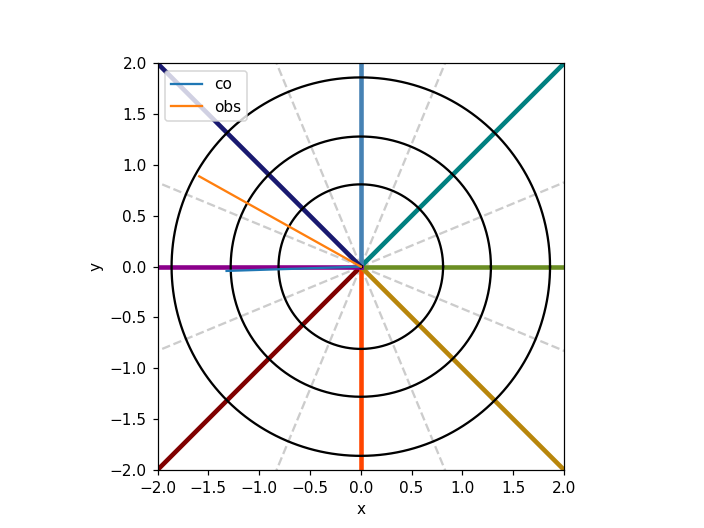

('target0:', 7)
('command angle:', 7)
('lag:', 1)
2303    1.957972
Name: diff_angle, dtype: float64


<IPython.core.display.Javascript object>


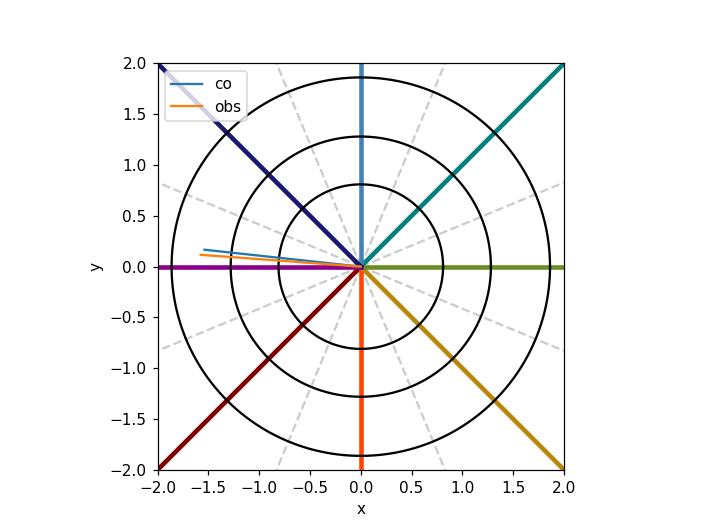

In [221]:
#PLOT: 
#To start with, pick a target and command bin: 
t0 = 7
t1 = (t0-1)%num_targets
bm = 2
ba = t0
l_list = [-1, 1]

t0_sel = (diff_df['target0']==t0)
t1_sel = (diff_df['target1']==t1)
bm_sel = (diff_df['mag_bin_current']==bm)
ba_sel = (diff_df['angle_bin_current']==ba)
for l in l_list: 
    l_sel = (diff_df['lag']==l)

    sel = t0_sel&t1_sel&bm_sel&ba_sel&l_sel
    # print(np.where(sel)[0])
    diff_df[sel]
    diff_df.loc[sel,'diff_angle']*180/np.pi

    print('target0:', t0)
    print('command angle:', ba)
    print('lag:', l)
    if any (np.where(sel)[0]):
        #----------------------------------------------------------------------------
        #Plot the u_vx at the specified lag: 
        x0 = diff_df.loc[sel, 'u_vx0']
        y0 = diff_df.loc[sel, 'u_vy0']

        x1 = diff_df.loc[sel, 'u_vx1']
        y1 = diff_df.loc[sel, 'u_vy1']

        print(diff_df.loc[sel,'diff_angle']*180/np.pi)

        plt.figure()
        plot_command_bin()

        plt.plot([0, x0], [0, y0], label=task_list[0])
        plt.plot([0, x1], [0, y1], label=task_list[1])
        plt.legend()
        plt.axis('square')
        plt.xlim(-2,2)
        plt.ylim(-2,2)
    else: 
        print('not enough samples...')

In [223]:
diff_df.head()

diff_mag  diff_angle    diff_x    diff_y  lag  mag_bin_current  \
0  0.259998   -0.099791 -0.171636 -0.235862   -5                0   
1  0.111768    0.387250 -0.337447  0.266060   -1                0   
2 -0.044855    0.014908  0.026114  0.037336    0                0   
3  0.114737    0.350367 -0.355770  0.222392    1                0   
4  0.121448    0.586315 -0.574630  0.122327    5                0   

   angle_bin_current  task0  target0  num_trials0     u_vx0     u_vy0  task1  \
0                  0      0        0            8 -1.269932 -0.724789      1   
1                  0      0        0            8 -1.021784 -0.495373      1   
2                  0      0        0            8 -0.367075 -0.360523      1   
3                  0      0        0            8 -1.027940 -0.650627      1   
4                  0      0        0            8 -0.682746 -0.807107      1   

   target1  num_trials1     u_vx1     u_vy1  
0        0           23 -1.098296 -0.488927  
1        0           23 -0.684337 -0.761433  
2        0           23 -0.393190 -0.397860  
3        0           23 -0.672170 -0.873020  
4        0           23 -0.108116 -0.929434

In [225]:
len(np.where(sel)[0])

593

<IPython.core.display.Javascript object>


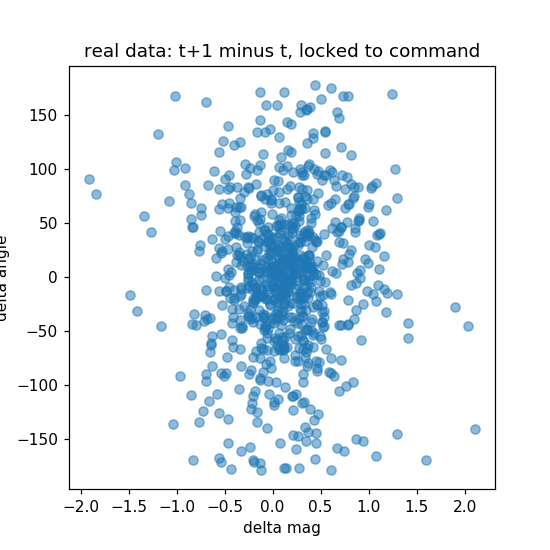

Text(0.5,1,'real data: t+1 minus t, locked to command')

In [242]:
lag_sel = (diff_df['lag']==1)
sel = lag_sel

diff_mag = diff_df['diff_mag'][sel]
diff_angle = diff_df['diff_angle'][sel]*180/np.pi
plt.figure(figsize=(5,5))
plt.scatter(diff_mag, diff_angle, alpha=0.5)
plt.ylabel('delta angle')
plt.xlabel('delta mag')
plt.title('real data: t+1 minus t, locked to command')

### Compare lag 0 to lag 1

In [51]:
mag_bin_edges


array([[0.00880115, 0.80946662, 1.28016195, 1.86169573],
       [0.80946662, 1.28016195, 1.86169573, 7.01433267]])

('num samples: ', 643)
('num samples: ', 643)


<IPython.core.display.Javascript object>


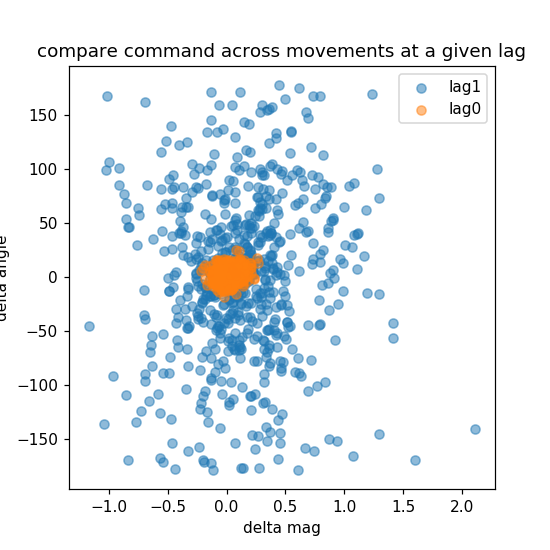

Text(0.5,1,'compare command across movements at a given lag')

In [58]:
#Compare lag 0 to lag 1
#PARAMS:
l=0
min_trials_analyze = 5
max_mag=2
#---------------------------------------------------------
#REAL:
lag_sel = (diff_df['lag']==l)
num_trials0_sel = (diff_df['num_trials0']>=min_trials_analyze) #5
num_trials1_sel = (diff_df['num_trials1']>=min_trials_analyze) #5
mag_sel = (diff_df['mag_bin_current']<=max_mag)

sel = (lag_sel)&(num_trials0_sel)&(num_trials1_sel)&(mag_sel)

print('num samples: ', len(np.where(sel)[0]))

diff_mag0 = diff_df['diff_mag'][sel]
diff_angle0 = diff_df['diff_angle'][sel]*180/np.pi

#---------------------------------------------------------
l=1
#---------------------------------------------------------
#REAL:
lag_sel = (diff_df['lag']==l)
num_trials0_sel = (diff_df['num_trials0']>=min_trials_analyze) #5
num_trials1_sel = (diff_df['num_trials1']>=min_trials_analyze) #5
mag_sel = (diff_df['mag_bin_current']<=max_mag)

sel = (lag_sel)&(num_trials0_sel)&(num_trials1_sel)&(mag_sel)

print('num samples: ', len(np.where(sel)[0]))

diff_mag1 = diff_df['diff_mag'][sel]
diff_angle1 = diff_df['diff_angle'][sel]*180/np.pi


#---------------------------------------------------------
#PLOT
plt.figure(figsize=(5,5))

plt.scatter(diff_mag1, diff_angle1, alpha=0.5, label='lag1')
plt.scatter(diff_mag0, diff_angle0, alpha=0.5, label='lag0')

plt.legend()

plt.ylabel('delta angle')
plt.xlabel('delta mag')
plt.title('compare command across movements at a given lag')
# plt.ylim(-180,180)
# plt.xlim(-2,2)

### Scatter the diff in angle and movement: Compare Real to Shuffle: 

In [24]:
#A) Scatter the real data
#B) Plot the covariance ellipse of: 1) across movement, 2) within movement, 3) shuffle

min_trials = 5
win = [0,1] #[0, 1]
num_win = win[1]-win[0]+1
num_var = len(list(df.columns))
psth_var = ['u_vx', 'u_vy']


task_target_bin_dic=bmi_b.calc_command_trials_dic_da(df, win, num_var, num_tasks, num_targets, num_mag_bins, num_angle_bins)
bmi_b.calc_command_psth(task_target_bin_dic, psth_var, min_trials, num_tasks, num_targets, num_mag_bins, num_angle_bins)

lags = [0, 1]
diff_df = bmi_b.calc_command_triggered_psth_diff_at_lag_across_task(lags, task_target_bin_dic, min_trials, num_mag_bins, num_angle_bins, num_targets)

(0, 0, 0, 0, 10)
(0, 0, 0, 1, 6)
(0, 0, 0, 2, 3)
(0, 0, 0, 3, 3)
(0, 0, 0, 4, 0)
(0, 0, 0, 5, 1)
(0, 0, 0, 6, 2)
(0, 0, 0, 7, 9)
(0, 0, 1, 0, 14)
(0, 0, 1, 1, 12)
(0, 0, 1, 2, 3)
(0, 0, 1, 3, 1)
(0, 0, 1, 4, 0)
(0, 0, 1, 5, 1)
(0, 0, 1, 6, 2)
(0, 0, 1, 7, 4)
(0, 0, 2, 0, 28)
(0, 0, 2, 1, 6)
(0, 0, 2, 2, 3)
(0, 0, 2, 3, 0)
(0, 0, 2, 4, 0)
(0, 0, 2, 5, 2)
(0, 0, 2, 6, 1)
(0, 0, 2, 7, 14)
(0, 0, 3, 0, 45)
(0, 0, 3, 1, 3)
(0, 0, 3, 2, 0)
(0, 0, 3, 3, 0)
(0, 0, 3, 4, 0)
(0, 0, 3, 5, 1)
(0, 0, 3, 6, 3)
(0, 0, 3, 7, 26)
(0, 1, 0, 0, 18)
(0, 1, 0, 1, 16)
(0, 1, 0, 2, 24)
(0, 1, 0, 3, 10)
(0, 1, 0, 4, 5)
(0, 1, 0, 5, 8)
(0, 1, 0, 6, 8)
(0, 1, 0, 7, 10)
(0, 1, 1, 0, 23)
(0, 1, 1, 1, 32)
(0, 1, 1, 2, 16)
(0, 1, 1, 3, 6)
(0, 1, 1, 4, 1)
(0, 1, 1, 5, 3)
(0, 1, 1, 6, 5)
(0, 1, 1, 7, 11)
(0, 1, 2, 0, 16)
(0, 1, 2, 1, 38)
(0, 1, 2, 2, 18)
(0, 1, 2, 3, 1)
(0, 1, 2, 4, 0)
(0, 1, 2, 5, 1)
(0, 1, 2, 6, 0)
(0, 1, 2, 7, 7)
(0, 1, 3, 0, 19)
(0, 1, 3, 1, 20)
(0, 1, 3, 2, 8)
(0, 1, 3, 3, 0)
(0, 1, 3, 4, 0)
(0,

(1, 7, 2, 6, 36)
(1, 7, 2, 7, 69)
(1, 7, 3, 0, 119)
(1, 7, 3, 1, 2)
(1, 7, 3, 2, 0)
(1, 7, 3, 3, 1)
(1, 7, 3, 4, 0)
(1, 7, 3, 5, 61)
(1, 7, 3, 6, 114)
(1, 7, 3, 7, 157)


('num samples: ', 797)


<IPython.core.display.Javascript object>


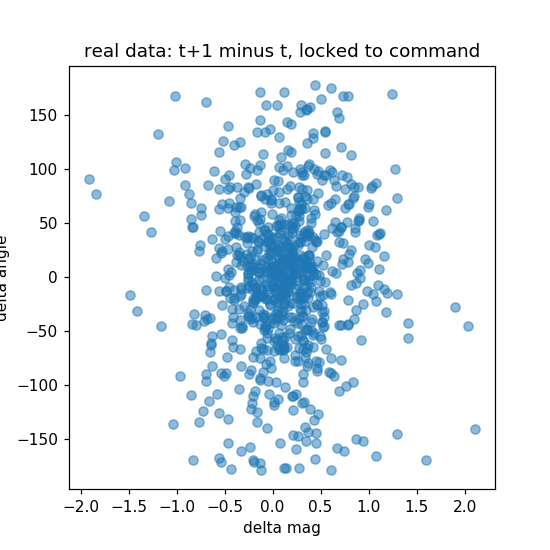

Text(0.5,1,'real data: t+1 minus t, locked to command')

In [25]:
lag_sel = (diff_df['lag']==1)
num_trials0_sel = (diff_df['num_trials0']>=5) #5
num_trials1_sel = (diff_df['num_trials1']>=5) #5

sel = (lag_sel)&(num_trials0_sel)&(num_trials1_sel)

print('num samples: ', len(np.where(sel)[0]))

diff_mag = diff_df['diff_mag'][sel]
diff_angle = diff_df['diff_angle'][sel]*180/np.pi
plt.figure(figsize=(5,5))
plt.scatter(diff_mag, diff_angle, alpha=0.5)
plt.ylabel('delta angle')
plt.xlabel('delta mag')
plt.title('real data: t+1 minus t, locked to command')

In [26]:
#SHUFFLE to compare: 
S_df = copy.deepcopy(df)
shuffle_var = ['u_px', 'u_py', 'u_vx', 'u_vy', 'kin_px', 'kin_py', 'kin_vx', 'kin_vy', 
               'p_mag', 'p_angle', 'v_mag', 'v_angle', 'u_p_mag', 'u_p_angle', 'u_v_mag', 'u_v_angle',
              'p_angle_ctr', 'v_angle_ctr', 'u_p_angle_ctr', 'u_v_angle_ctr', 'u_v_mag_bin', 'u_v_angle_bin']
S_data = np.array(S_df.loc[:, shuffle_var])
# rng = np.random.default_rng()
# rng.shuffle(S_data,axis=0)
np.random.shuffle(S_data) #shuffles along axis=0
S_df.loc[:,shuffle_var] = S_data
#-----------------------------------------------------------------------------------------------------------------

# #RERUN ANALYSIS: 
S_task_target_bin_dic=bmi_b.calc_command_trials_dic_da(S_df, win, num_var, num_tasks, num_targets, num_mag_bins, num_angle_bins)
bmi_b.calc_command_psth(S_task_target_bin_dic, psth_var, min_trials, num_tasks, num_targets, num_mag_bins, num_angle_bins)

lags = [0, 1]
S_diff_df = bmi_b.calc_command_triggered_psth_diff_at_lag_across_task(lags, S_task_target_bin_dic, min_trials, num_mag_bins, num_angle_bins, num_targets)

(0, 0, 0, 0, 6)
(0, 0, 0, 1, 6)
(0, 0, 0, 2, 5)
(0, 0, 0, 3, 7)
(0, 0, 0, 4, 4)
(0, 0, 0, 5, 10)
(0, 0, 0, 6, 8)
(0, 0, 0, 7, 6)
(0, 0, 1, 0, 11)
(0, 0, 1, 1, 8)
(0, 0, 1, 2, 7)
(0, 0, 1, 3, 3)
(0, 0, 1, 4, 7)
(0, 0, 1, 5, 3)
(0, 0, 1, 6, 4)
(0, 0, 1, 7, 7)
(0, 0, 2, 0, 5)
(0, 0, 2, 1, 11)
(0, 0, 2, 2, 7)
(0, 0, 2, 3, 12)
(0, 0, 2, 4, 1)
(0, 0, 2, 5, 7)
(0, 0, 2, 6, 4)
(0, 0, 2, 7, 6)
(0, 0, 3, 0, 6)
(0, 0, 3, 1, 2)
(0, 0, 3, 2, 1)
(0, 0, 3, 3, 2)
(0, 0, 3, 4, 4)
(0, 0, 3, 5, 21)
(0, 0, 3, 6, 6)
(0, 0, 3, 7, 6)
(0, 1, 0, 0, 12)
(0, 1, 0, 1, 8)
(0, 1, 0, 2, 14)
(0, 1, 0, 3, 9)
(0, 1, 0, 4, 10)
(0, 1, 0, 5, 7)
(0, 1, 0, 6, 5)
(0, 1, 0, 7, 11)
(0, 1, 1, 0, 14)
(0, 1, 1, 1, 9)
(0, 1, 1, 2, 14)
(0, 1, 1, 3, 10)
(0, 1, 1, 4, 12)
(0, 1, 1, 5, 10)
(0, 1, 1, 6, 11)
(0, 1, 1, 7, 8)
(0, 1, 2, 0, 10)
(0, 1, 2, 1, 10)
(0, 1, 2, 2, 13)
(0, 1, 2, 3, 12)
(0, 1, 2, 4, 14)
(0, 1, 2, 5, 7)
(0, 1, 2, 6, 8)
(0, 1, 2, 7, 8)
(0, 1, 3, 0, 14)
(0, 1, 3, 1, 6)
(0, 1, 3, 2, 5)
(0, 1, 3, 3, 5)
(0, 1, 3, 4, 10)
(0

(1, 7, 1, 7, 20)
(1, 7, 2, 0, 27)
(1, 7, 2, 1, 30)
(1, 7, 2, 2, 29)
(1, 7, 2, 3, 16)
(1, 7, 2, 4, 28)
(1, 7, 2, 5, 23)
(1, 7, 2, 6, 23)
(1, 7, 2, 7, 21)
(1, 7, 3, 0, 33)
(1, 7, 3, 1, 16)
(1, 7, 3, 2, 14)
(1, 7, 3, 3, 8)
(1, 7, 3, 4, 17)
(1, 7, 3, 5, 45)
(1, 7, 3, 6, 36)
(1, 7, 3, 7, 35)


('num samples: ', 1752)


<IPython.core.display.Javascript object>


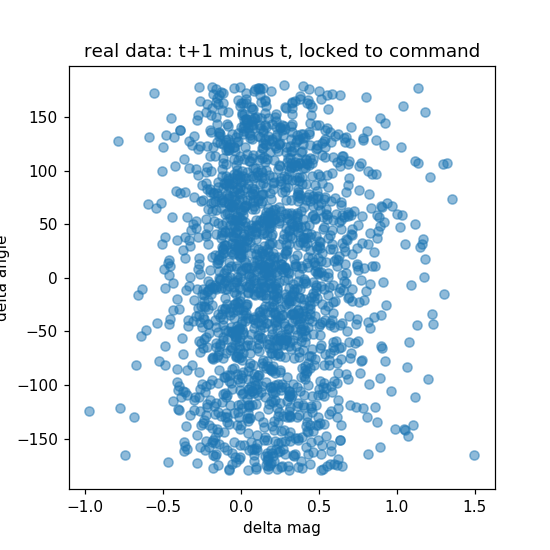

Text(0.5,1,'real data: t+1 minus t, locked to command')

In [27]:
lag_sel = (S_diff_df['lag']==1)
num_trials0_sel = (S_diff_df['num_trials0']>=5) #5
num_trials1_sel = (S_diff_df['num_trials1']>=5) #5

sel = (lag_sel)&(num_trials0_sel)&(num_trials1_sel)
print('num samples: ', len(np.where(sel)[0]))

S_diff_mag = S_diff_df['diff_mag'][sel]
S_diff_angle = S_diff_df['diff_angle'][sel]*180/np.pi
plt.figure(figsize=(5,5))
plt.scatter(S_diff_mag, S_diff_angle, alpha=0.5)
plt.ylabel('delta angle')
plt.xlabel('delta mag')
plt.title('real data: t+1 minus t, locked to command')

<IPython.core.display.Javascript object>


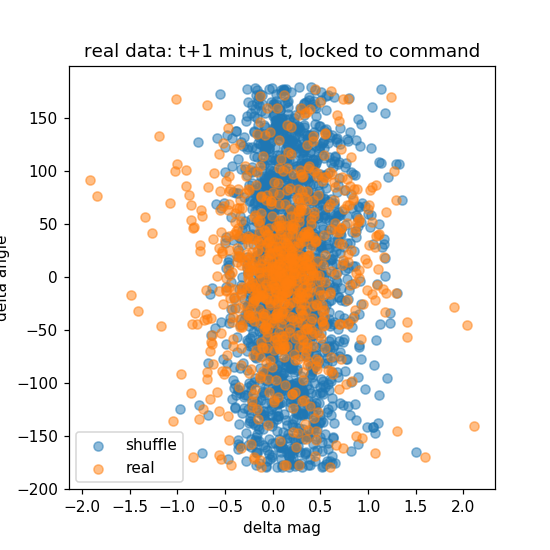

Text(0.5,1,'real data: t+1 minus t, locked to command')

In [28]:
plt.figure(figsize=(5,5))


plt.scatter(S_diff_mag, S_diff_angle, alpha=0.5, label='shuffle')
plt.scatter(diff_mag, diff_angle, alpha=0.5, label='real')
plt.legend()


plt.ylabel('delta angle')
plt.xlabel('delta mag')
plt.title('real data: t+1 minus t, locked to command')

In [35]:
list(diff_df.columns)

['diff_mag',
 'diff_angle',
 'diff_x',
 'diff_y',
 'lag',
 'mag_bin_current',
 'angle_bin_current',
 'task0',
 'target0',
 'num_trials0',
 'u_vx0',
 'u_vy0',
 'task1',
 'target1',
 'num_trials1',
 'u_vx1',
 'u_vy1']

In [42]:
mag_bin_edges

array([[0.00880115, 0.80946662, 1.28016195, 1.86169573],
       [0.80946662, 1.28016195, 1.86169573, 7.01433267]])

('num samples: ', 643)
('num samples: ', 1384)


<IPython.core.display.Javascript object>


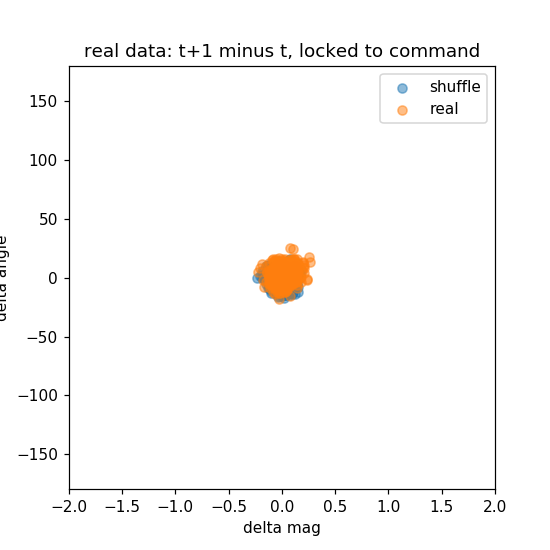

(-2, 2)

In [43]:
#Plot lag = 0: 
#PARAMS:
l=0
min_trials_analyze = 5
max_mag=2
#---------------------------------------------------------
#REAL:
lag_sel = (diff_df['lag']==l)
num_trials0_sel = (diff_df['num_trials0']>=min_trials_analyze) #5
num_trials1_sel = (diff_df['num_trials1']>=min_trials_analyze) #5
mag_sel = (diff_df['mag_bin_current']<=max_mag)

sel = (lag_sel)&(num_trials0_sel)&(num_trials1_sel)&(mag_sel)

print('num samples: ', len(np.where(sel)[0]))

diff_mag = diff_df['diff_mag'][sel]
diff_angle = diff_df['diff_angle'][sel]*180/np.pi

#---------------------------------------------------------
#SHUFFLE: 
lag_sel = (S_diff_df['lag']==l)
num_trials0_sel = (S_diff_df['num_trials0']>=min_trials_analyze) #5
num_trials1_sel = (S_diff_df['num_trials1']>=min_trials_analyze) #5
mag_sel = (S_diff_df['mag_bin_current']<=max_mag)

sel = (lag_sel)&(num_trials0_sel)&(num_trials1_sel)&(mag_sel)
print('num samples: ', len(np.where(sel)[0]))

S_diff_mag = S_diff_df['diff_mag'][sel]
S_diff_angle = S_diff_df['diff_angle'][sel]*180/np.pi

#---------------------------------------------------------
#PLOT
plt.figure(figsize=(5,5))

plt.scatter(S_diff_mag, S_diff_angle, alpha=0.5, label='shuffle')
plt.scatter(diff_mag, diff_angle, alpha=0.5, label='real')
plt.legend()

plt.ylabel('delta angle')
plt.xlabel('delta mag')
plt.title('real data: t+1 minus t, locked to command')
plt.ylim(-180,180)
plt.xlim(-2,2)

In [ ]:
#CONFIRM: 
#how can there be so much difference even within the same bin... 
#check for small mag bins
#confirm that the (u_vx0, u_vy0), (u_vx1, u_vy1) are in correct bin

In [33]:
360.0/8

45.0

In [32]:
diff_df.head()

diff_mag  diff_angle    diff_x    diff_y  lag  mag_bin_current  \
0 -0.103341    0.033649  0.059476  0.086150    0                0   
1  0.100355    0.352659 -0.329918  0.246069    1                0   
2 -0.089044    0.011196  0.058487  0.067367    0                0   
3  0.456982    0.589311 -0.705294  0.070860    1                0   
4 -0.125125    0.011928  0.083335  0.093532    0                0   

   angle_bin_current  task0  target0  num_trials0     u_vx0     u_vy0  task1  \
0                  0      0        0           10 -0.315999 -0.317879      1   
1                  0      0        0           10 -1.037001 -0.581705      1   
2                  0      0        0           10 -0.315999 -0.317879      1   
3                  0      0        0           10 -1.037001 -0.581705      1   
4                  0      0        0           10 -0.315999 -0.317879      1   

   target1  num_trials1     u_vx1     u_vy1  
0        0           32 -0.375475 -0.404029  
1        0           32 -0.707083 -0.827774  
2        1           47 -0.374486 -0.385246  
3        1           47 -0.331707 -0.652565  
4        2           38 -0.399334 -0.411411

### psth diff histograms: 

In [13]:
df.head()

n_0  n_1  n_2  n_3  n_4  n_5  n_6  n_7  n_8  n_9  ...  u_v_angle  \
0  2.0  1.0  0.0  0.0  1.0  4.0  2.0  0.0  0.0  0.0  ...   1.903203   
1  2.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0  ...   1.343763   
2  1.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  ...   1.107820   
3  5.0  0.0  0.0  1.0  0.0  4.0  4.0  0.0  0.0  0.0  ...  -1.608672   
4  4.0  0.0  0.0  0.0  1.0  3.0  0.0  0.0  0.0  0.0  ...   1.202795   

   p_angle_ctr  v_angle_ctr  u_p_angle_ctr  u_v_angle_ctr   d2target  \
0     3.089594    -2.668033      -2.023787      -2.023787  18.560671   
1     3.107998    -2.663977      -2.583228      -2.583228  18.844048   
2     3.122842    -2.811559      -2.819171      -2.819171  19.180040   
3     3.121874     2.781544       0.747523       0.747523  19.319563   
4     3.122433    -3.084737      -2.724196      -2.724196  19.482174   

     x_error    y_error  u_v_mag_bin  u_v_angle_bin  
0  13.435452  12.805746          1.0            5.0  
1  13.533209  13.112986          3.0            5.0  
2  13.683511  13.440069          2.0            4.0  
3  13.790328  13.530425          1.0            1.0  
4  13.903848  13.646909          1.0            5.0  

[5 rows x 80 columns]

In [16]:
#NOTE: This takes some time...
min_trials = 5
win = [-5,5] #[0, 1]
num_win = win[1]-win[0]+1
num_var = len(list(df.columns))
psth_var = ['u_vx', 'u_vy']
task_pairs = [(0,0), (0,1), (1,1)]
if win[0] <= 0:
    zero_lag_idx = -win[0]

task_target_bin_dic=bmi_b.calc_command_trials_dic_da(df, win, num_var, num_tasks, num_targets, num_mag_bins, num_angle_bins)
bmi_b.calc_command_psth(task_target_bin_dic, psth_var, min_trials, num_tasks, num_targets, num_mag_bins, num_angle_bins)
diff_df = bmi_b.calc_command_psth_diff(task_target_bin_dic, task_pairs, zero_lag_idx, min_trials, num_targets, num_mag_bins, num_angle_bins)

(0, 0, 0, 0, 8)
(0, 0, 0, 1, 3)
(0, 0, 0, 2, 2)
(0, 0, 0, 3, 3)
(0, 0, 0, 4, 0)
(0, 0, 0, 5, 1)
(0, 0, 0, 6, 2)
(0, 0, 0, 7, 5)
(0, 0, 1, 0, 10)
(0, 0, 1, 1, 7)
(0, 0, 1, 2, 2)
(0, 0, 1, 3, 1)
(0, 0, 1, 4, 0)
(0, 0, 1, 5, 1)
(0, 0, 1, 6, 2)
(0, 0, 1, 7, 3)
(0, 0, 2, 0, 19)
(0, 0, 2, 1, 5)
(0, 0, 2, 2, 2)
(0, 0, 2, 3, 0)
(0, 0, 2, 4, 0)
(0, 0, 2, 5, 2)
(0, 0, 2, 6, 0)
(0, 0, 2, 7, 11)
(0, 0, 3, 0, 29)
(0, 0, 3, 1, 3)
(0, 0, 3, 2, 0)
(0, 0, 3, 3, 0)
(0, 0, 3, 4, 0)
(0, 0, 3, 5, 1)
(0, 0, 3, 6, 1)
(0, 0, 3, 7, 17)
(0, 1, 0, 0, 14)
(0, 1, 0, 1, 14)
(0, 1, 0, 2, 19)
(0, 1, 0, 3, 8)
(0, 1, 0, 4, 4)
(0, 1, 0, 5, 8)
(0, 1, 0, 6, 8)
(0, 1, 0, 7, 5)
(0, 1, 1, 0, 18)
(0, 1, 1, 1, 23)
(0, 1, 1, 2, 14)
(0, 1, 1, 3, 4)
(0, 1, 1, 4, 1)
(0, 1, 1, 5, 3)
(0, 1, 1, 6, 3)
(0, 1, 1, 7, 8)
(0, 1, 2, 0, 9)
(0, 1, 2, 1, 31)
(0, 1, 2, 2, 17)
(0, 1, 2, 3, 1)
(0, 1, 2, 4, 0)
(0, 1, 2, 5, 1)
(0, 1, 2, 6, 0)
(0, 1, 2, 7, 3)
(0, 1, 3, 0, 11)
(0, 1, 3, 1, 17)
(0, 1, 3, 2, 8)
(0, 1, 3, 3, 0)
(0, 1, 3, 4, 0)
(0, 1, 3,

(1, 7, 2, 7, 55)
(1, 7, 3, 0, 96)
(1, 7, 3, 1, 1)
(1, 7, 3, 2, 0)
(1, 7, 3, 3, 1)
(1, 7, 3, 4, 0)
(1, 7, 3, 5, 40)
(1, 7, 3, 6, 72)
(1, 7, 3, 7, 139)


In [18]:
diff_df.head()

diff_norm  mag_bin  angle_bin  task0  target0  num_trials0     u_vx0  \
0   2.654690        0          0      0        0            8 -0.361275   
1   2.848698        0          7      0        0            5 -0.258118   
2   2.446858        1          0      0        0           10 -0.613142   
3   3.348114        1          1      0        0            7 -1.227048   
4   1.848567        2          0      0        0           19 -0.500970   

      u_vy0  task1  target1  num_trials1     u_vx1     u_vy1  
0 -0.824432      0        0            8 -1.004217 -0.789782  
1  0.554594      0        0            5 -0.307243 -0.607369  
2 -0.746127      0        0           10 -0.521383 -0.701839  
3  0.120087      0        0            7 -1.320913 -0.093335  
4 -0.707174      0        0           19 -1.552742 -0.162996

In [24]:
#COMPARE WITHIN AND ACROSS MOVE: 

#accumulate the differences: 
min_trials_analyze = 15
max_mag=3

#sel: 
num_trials0_sel = (diff_df['num_trials0']>=min_trials_analyze) #5
num_trials1_sel = (diff_df['num_trials1']>=min_trials_analyze) #5
mag_sel = (diff_df['mag_bin']<=max_mag)

sel_universal = \
    num_trials0_sel\
    &num_trials1_sel\
    &mag_sel

move_sel_dic = {}
move_list = ['all', 'within_move', 'within_task', 'within_co', 'within_obs', 'across_task', 'across_move']
move_sel_dic['all', 'sel'] = sel_universal
move_sel_dic['within_move', 'sel'] = (diff_df['target0']==diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
move_sel_dic['within_task', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
move_sel_dic['within_co', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==0)
move_sel_dic['within_obs', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==1)
move_sel_dic['across_task', 'sel'] = (diff_df['task0']!=diff_df['task1'])
move_sel_dic['across_move', 'sel'] = (diff_df['task0']!=diff_df['task1'])|(diff_df['target0']!=diff_df['target1'])


for move in move_list: 
    sel = sel_universal\
    &move_sel_dic[move,'sel']
    move_sel_dic[move, 'diff_norm'] = np.array(diff_df['diff_norm'][sel])

In [29]:
bin_max = round(move_sel_dic['all', 'diff_norm'].max())
num_bins = 30
diff_bins = np.linspace(0,bin_max,num_bins)
bin_edges = np.array([diff_bins[:-1], diff_bins[1:]])
bin_dic = {0:bin_edges}                     

for move in move_list: 
    d = move_sel_dic[move, 'diff_norm']
    br, hr = bmi_b.bin_vec_data(d.reshape(-1,1), bin_dic)
    pmf = hr/np.sum(hr)
    cmf = np.cumsum(pmf)
    move_sel_dic[move, 'hist'] = hr
    move_sel_dic[move, 'pmf'] = pmf
    move_sel_dic[move, 'cmf'] = cmf

<IPython.core.display.Javascript object>


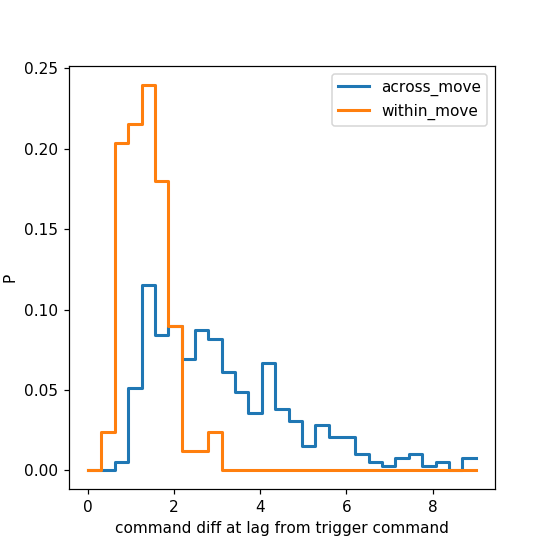

<IPython.core.display.Javascript object>


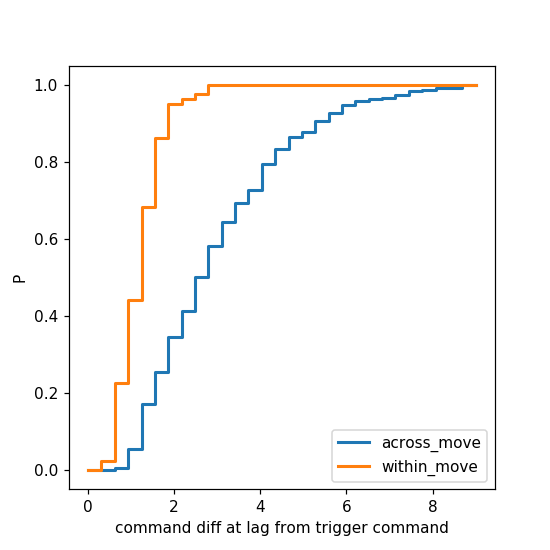

In [27]:
save_bool = False
ext_list = ['.png','.eps']
title_str = 'command_trig_psth_diff_within_vs_across_move_STAIR'
move_plot =  ['across_move', 'within_move']
d_plot = ['pmf', 'cmf']

for var in d_plot:
    plt.figure(figsize=(5,5))
    for move in move_plot: 
        d = move_sel_dic[move,var]
        bmi_b.plot_hist_stair(bin_edges, d, label=move) 
    plt.legend()
    plt.xlabel('command diff at lag from trigger command')
    plt.ylabel('P')
    if save_bool: 
        for ext in ext_list:
            save_path = os.path.join(save_dir, title_str+'_'+var+'_obs'+str(min_trials_analyze)+ext)
            plt.savefig(save_path)

In [31]:
win

[-5, 5]

<IPython.core.display.Javascript object>


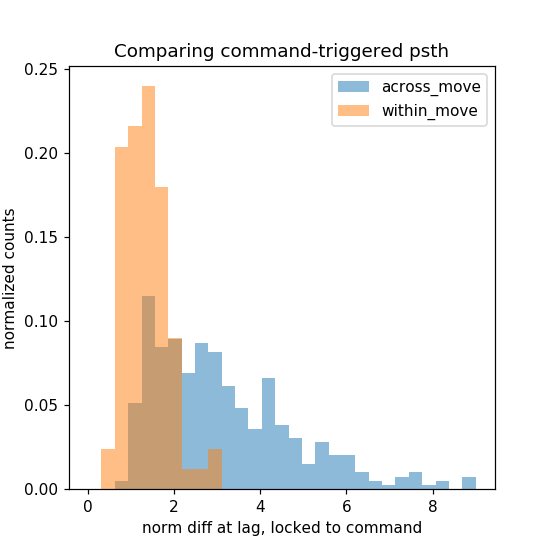

In [34]:
save_bool = True
ext_list = ['.png','.eps']
move_plot =  ['across_move', 'within_move']
#['across_move', 'within_obs', 'within_co', 'within_move']
num_lags = win[1]-win[0]+1
title_str = 'command_trig_psth_lags' + str(num_lags) + '_diff_within_vs_across_move_BAR'

bin_max = round(move_sel_dic['all', 'diff_norm'].max())
num_bins = 30
diff_bins = np.linspace(0,bin_max,num_bins)

plt.figure(figsize=(5,5))
for move in move_plot: 
    d = move_sel_dic[move, 'diff_norm']
    
    plt.hist(d, diff_bins, weights=np.ones_like(d)/len(d), alpha=0.5, label=move)

plt.legend()
plt.xlabel('norm diff at lag, locked to command')
plt.ylabel('normalized counts')
plt.title('Comparing command-triggered psth')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, title_str+'_obs'+str(min_trials_analyze)+ext)
        plt.savefig(save_path)

In [33]:
save_path

'D:\\Dropbox\\BMI_co_obs_paper\\data\\vivek\\command_compare\\command_trig_psth_lags11_diff_within_vs_across_move_BAR_obs15.eps'

### Obselete: SHUFFLE data to compare

In [70]:
#SHUFFLE all the behavior var: 
S_df = copy.deepcopy(df)
shuffle_var = ['u_px', 'u_py', 'u_vx', 'u_vy', 'kin_px', 'kin_py', 'kin_vx', 'kin_vy', 
               'p_mag', 'p_angle', 'v_mag', 'v_angle', 'u_p_mag', 'u_p_angle', 'u_v_mag', 'u_v_angle',
              'p_angle_ctr', 'v_angle_ctr', 'u_p_angle_ctr', 'u_v_angle_ctr', 'u_v_mag_bin', 'u_v_angle_bin']
S_data = np.array(S_df.loc[:, shuffle_var])
np.random.shuffle(S_data)
S_df.loc[:,shuffle_var] = S_data

#RERUN ANALYSIS: 
S_task_target_bin_dic=bmi_b.calc_command_trials_dic_da(S_df, win, num_var, num_tasks, num_targets, num_mag_bins, num_angle_bins)
bmi_b.calc_command_psth(S_task_target_bin_dic, psth_var, min_trials, num_tasks, num_targets, num_mag_bins, num_angle_bins)
S_da_diff, S_d_accum = bmi_b.calc_command_psth_diff(S_task_target_bin_dic, min_trials, num_targets, num_mag_bins, num_angle_bins)

(0, 0, 0, 0, 5)
(0, 0, 0, 1, 4)
(0, 0, 0, 2, 7)
(0, 0, 0, 3, 7)
(0, 0, 0, 4, 9)
(0, 0, 0, 5, 4)
(0, 0, 0, 6, 6)
(0, 0, 0, 7, 7)
(0, 0, 1, 0, 9)
(0, 0, 1, 1, 4)
(0, 0, 1, 2, 7)
(0, 0, 1, 3, 9)
(0, 0, 1, 4, 4)
(0, 0, 1, 5, 5)
(0, 0, 1, 6, 10)
(0, 0, 1, 7, 10)
(0, 0, 2, 0, 10)
(0, 0, 2, 1, 7)
(0, 0, 2, 2, 4)
(0, 0, 2, 3, 6)
(0, 0, 2, 4, 8)
(0, 0, 2, 5, 6)
(0, 0, 2, 6, 2)
(0, 0, 2, 7, 5)
(0, 0, 3, 0, 4)
(0, 0, 3, 1, 2)
(0, 0, 3, 2, 2)
(0, 0, 3, 3, 3)
(0, 0, 3, 4, 4)
(0, 0, 3, 5, 9)
(0, 0, 3, 6, 13)
(0, 0, 3, 7, 11)
(0, 1, 0, 0, 10)
(0, 1, 0, 1, 15)
(0, 1, 0, 2, 13)
(0, 1, 0, 3, 6)
(0, 1, 0, 4, 14)
(0, 1, 0, 5, 3)
(0, 1, 0, 6, 8)
(0, 1, 0, 7, 11)
(0, 1, 1, 0, 9)
(0, 1, 1, 1, 10)
(0, 1, 1, 2, 14)
(0, 1, 1, 3, 9)
(0, 1, 1, 4, 7)
(0, 1, 1, 5, 8)
(0, 1, 1, 6, 9)
(0, 1, 1, 7, 5)
(0, 1, 2, 0, 6)
(0, 1, 2, 1, 11)
(0, 1, 2, 2, 12)
(0, 1, 2, 3, 12)
(0, 1, 2, 4, 11)
(0, 1, 2, 5, 13)
(0, 1, 2, 6, 7)
(0, 1, 2, 7, 11)
(0, 1, 3, 0, 16)
(0, 1, 3, 1, 5)
(0, 1, 3, 2, 8)
(0, 1, 3, 3, 0)
(0, 1, 3, 4, 12)
(0, 

(1, 7, 1, 5, 21)
(1, 7, 1, 6, 21)
(1, 7, 1, 7, 18)
(1, 7, 2, 0, 28)
(1, 7, 2, 1, 36)
(1, 7, 2, 2, 16)
(1, 7, 2, 3, 24)
(1, 7, 2, 4, 28)
(1, 7, 2, 5, 20)
(1, 7, 2, 6, 23)
(1, 7, 2, 7, 27)
(1, 7, 3, 0, 31)
(1, 7, 3, 1, 13)
(1, 7, 3, 2, 19)
(1, 7, 3, 3, 6)
(1, 7, 3, 4, 17)
(1, 7, 3, 5, 46)
(1, 7, 3, 6, 43)
(1, 7, 3, 7, 30)


In [51]:
# df.loc[0:10, ['u_v_mag_bin', 'u_v_angle_bin']]

In [52]:
# S_df.loc[0:10, ['u_v_mag_bin', 'u_v_angle_bin']]

In [57]:
win

[0, 1]

### PLOT real vs shuffle: 

In [71]:
#make a fixed set of bins: 
diff_bins = np.linspace(0,5,40)
diff_bins_e = np.array([diff_bins[0:-1], diff_bins[1:]])

In [302]:
num_win

11

In [60]:
len(d_accum)

797

In [61]:
len(S_d_accum)

1712

In [49]:
num_win

3

<IPython.core.display.Javascript object>


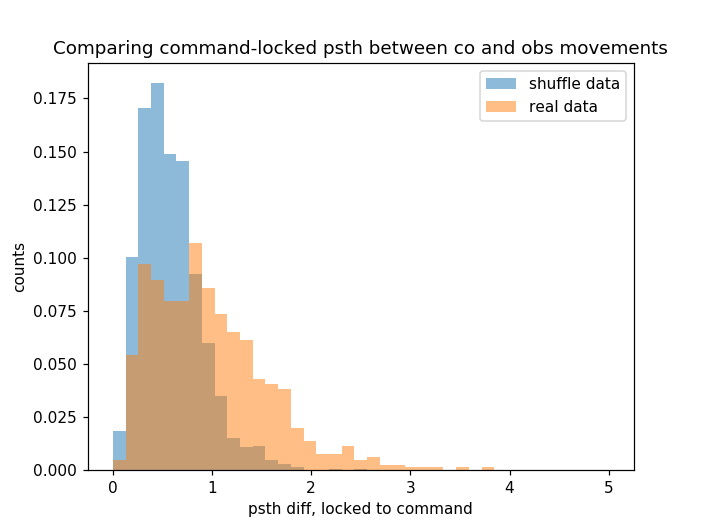

In [68]:
save_bool  = True
ext_list = ['.png', '.eps']

plt.figure()
d_weights = np.ones_like(d_accum)/len(d_accum)
S_d_weights = np.ones_like(S_d_accum)/len(S_d_accum)

plt.hist(S_d_accum, diff_bins, weights=S_d_weights, alpha=0.5, label='shuffle data')
plt.hist(d_accum, diff_bins, weights=d_weights, alpha=0.5, label='real data')

plt.legend()
plt.xlabel('psth diff, locked to command')
plt.ylabel('counts')
plt.title('Comparing command-locked psth between co and obs movements')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, 'command_psth_diff_across_task'+'_prev'+str(win[0])+'_next'+str(win[1])+ext)
        plt.savefig(save_path)

In [67]:
save_path = os.path.join(save_dir, 'command_psth_diff_across_task'+'_prev'+str(win[0])+'_next'+str(win[1])+ext)
print(save_path)

D:\Dropbox\BMI_co_obs_paper\data\vivek\command_compare\command_psth_diff_across_task_prev-1_next0.eps
